# APB因子综合测试 Average Price Bias (APB)

原文：https://github.com/hugo2046/QuantsPlaybook/blob/master/B-因子构建类/基于量价关系度量股票的买卖压力/20191029-东方证券-%20因子选股系列研究六十：基于量价关系度量股票的买卖压力.pdf

### 定义 Definition
$$APB_{i,m}=ln(\frac{\frac{1}{T}\sum^T_{i=1}vwap^{t}_{i,m}}{\frac{1}{\sum^T_{t=1}volu^{t}_{i,m}}\sum^T_{t=1}volu^t_{i,m}·vwap^t_{i,m}})$$

**解释：如果股票在价格高位成交量大，那么成交量加权的均值大于算术平均，APB 取值小于零，相反，如果股票在价格低位成交量大，那么成交量加权的均值小于算术平均，APB 取值大于零，APB 取值越大，股票面临的买压越大，卖压越小。**

**Explanation: If a stock trades at high prices with large volumes, the volume-weighted average will be greater than the arithmetic average, resulting in a negative APB value. Conversely, if a stock trades at low prices with large volumes, the volume-weighted average will be less than the arithmetic average, resulting in a positive APB value. The larger the APB value, the greater the buying pressure and the smaller the selling pressure the stock faces.**

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [11]:
# 计算一列apb因子
def insert_apb_col(data, num_ticks):

    # 定义计算apb的函数
    def calculate_apb(df):
        min_a = 0.998/1.002
        max_a = 1.002/0.998
        
        temp = np.mean(df['vwap']) / np.average(df['vwap'], weights=df['tick_vol'])
        apb = 2 * (temp - min_a) / (max_a - min_a) - 1
        
        apb = max(-1.0, apb)
        apb = min(1.0, apb)
        
        return apb
    
    results = []

    # 对每个分组应用滚动计算
    for date, group in data.groupby('date'):
        group = group.copy()
        apb_values = []
        for i in range(len(group)):
            if i < num_ticks-1:
                apb_values.append(np.nan)
            else:
                window = group.iloc[i-num_ticks+1:i+1]  # 取过去20个tick的数据窗口
                apb = calculate_apb(window)
                apb_values.append(apb)
        group[f'apb_{num_ticks}'] = apb_values
        results.append(group)

    # 合并结果
    result = pd.concat(results)

    result = result.dropna(subset=[f'apb_{num_ticks}'])
    result = result.reset_index(drop=True)
    
    return result

In [12]:
# 画出因子分布直方图
def print_factor_dist(data, fac_name):
    data[fac_name].hist(bins=50)
    plt.show()
    print(data[fac_name].min(), data[fac_name].mean(), data[fac_name].max())

In [13]:
# 分组求平均值
def calculate_group_average(data, factor_name, y_name):
    # 将数据按日期排序
    data = data.sort_values('datetime').reset_index(drop=True)
    unique_dates = data['date'].unique()

    # 初始化结果存储
    results_std = pd.DataFrame(columns=['date', factor_name, y_name, 'group_std'])
    results_percent = pd.DataFrame(columns=['date', factor_name, y_name, 'group_percent'])

    # 循环进行训练和测试
    for start_day in range(0, len(unique_dates) - 10, 5):
        pastdays = start_day + 5  # 前5天数据
        futuredays = pastdays + 5  # 接下来的5天数据

        if futuredays >= len(unique_dates):
            break

        # 定义训练集和测试集
        past_data = data[(data['date'] >= unique_dates[start_day]) & (data['date'] <= unique_dates[pastdays])]
        future_data = data[(data['date'] > unique_dates[pastdays]) & (data['date'] <= unique_dates[futuredays])]
        
        # *********************根据标准差分组*********************
        # 计算过去天的势能的标准差
        std_dev = past_data[factor_name].std()
        # mean_val = past_data['apb'].mean()

        # 定义分组区间
        bins_std = [-np.inf, - 3 * std_dev,  - 2 * std_dev,  - std_dev, + std_dev,  + 2 * std_dev,  + 3 * std_dev, np.inf]
        labels_std = ['-∞ to -3σ', '-3σ to -2σ', '-2σ to -σ', '-σ to +σ', '+σ to +2σ', '+2σ to +3σ', '+3σ to +∞']

        temp_std = future_data[['date', factor_name, y_name]].copy()
        temp_std['group_std'] = pd.cut(temp_std[factor_name], bins=bins_std, labels=labels_std)

        # 合并结果并重置索引
        results_std = pd.concat([results_std, temp_std]).reset_index(drop=True)
        
        # *********************根据分位数分组*********************
        # 计算训练集最后天预测值的百分位数
        percentiles = np.percentile(past_data[factor_name], [0, 20, 40, 60, 80, 100])

        # 将预测值按照百分位数分为5组
        bins_percent = percentiles
        labels_percent = ['0-20%', '20-40%', '40-60%', '60-80%', '80-100%']
        
        temp_percent = future_data[['date', factor_name, y_name]].copy()
        temp_percent['group_percent'] = pd.cut(temp_percent[factor_name], bins=bins_percent, labels=labels_percent)

        # 合并结果并重置索引
        results_percent = pd.concat([results_percent, temp_percent]).reset_index(drop=True)
    
    return results_std, results_percent

In [14]:
# 打印分组的结果
def print_grouped_results(data, factor_name, y_name):
    results_std, results_percent = calculate_group_average(data, factor_name, y_name)

    # 计算每组的平均值
    grouped_means_std = results_std.groupby('group_std').mean(numeric_only=True).reset_index()

    # 绘制每组的平均值比较（按标准差分组）
    grouped_means_std[y_name].plot(kind='bar')
    plt.title(f'Average values of {factor_name} and {y_name} in each group (Standard Deviation)')
    plt.xlabel('Group')
    plt.ylabel('Average Value')
    plt.grid(True)
    plt.show()

    print(grouped_means_std)

    # 计算每组的平均值
    grouped_means_percent = results_percent.groupby('group_percent').mean(numeric_only=True).reset_index()

    # 绘制每组的平均值比较（按标准差分组）
    grouped_means_percent[y_name].plot(kind='bar')
    plt.title(f'Average values of {factor_name} and {y_name} in each group (Percentage)')
    plt.xlabel('Group')
    plt.ylabel('Average Value')
    plt.grid(True)
    plt.show()

    print(grouped_means_percent)

In [15]:
def assess_apb_wrt_return(data, back_ticks, y_name):
    data1 = insert_apb_col(data, back_ticks)
    data2 = data1[['datetime', 'date', f'apb_{back_ticks}', y_name]]
    
    print_factor_dist(data2, f'apb_{back_ticks}')
    print_grouped_results(data2, f'apb_{back_ticks}', y_name)

In [16]:
data = pd.read_csv('data/data_with_minute_returns.csv', dtype={'date': str, 'time': str})
data['datetime'] = pd.to_datetime(data['datetime'])

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 475405 entries, 0 to 475404
Data columns (total 32 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Unnamed: 0.1  475405 non-null  int64         
 1   Unnamed: 0    475405 non-null  int64         
 2   stk           475405 non-null  object        
 3   date          475405 non-null  object        
 4   time          475405 non-null  object        
 5   tick_vol      475405 non-null  float64       
 6   tick_amt      475405 non-null  float64       
 7   spread        475405 non-null  float64       
 8   mid_px        475405 non-null  float64       
 9   vwap          475405 non-null  float64       
 10  new_price     475405 non-null  float64       
 11  ap1           475405 non-null  float64       
 12  bp1           475405 non-null  float64       
 13  av1           475405 non-null  float64       
 14  bv1           475405 non-null  float64       
 15  ym_3          475

In [17]:
y_names_list = ['ym_3', 'ym_5', 'ym_10', 'y_1min', 'y_3min', 'y_5min', 'y_7min', 'y_10min']

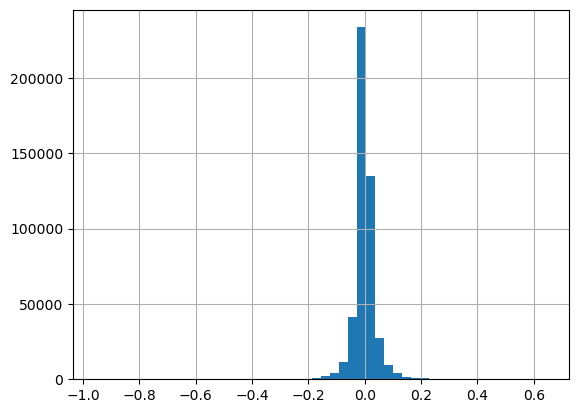

-0.9559484420865437 -0.00016863496419868584 0.6447316929333218


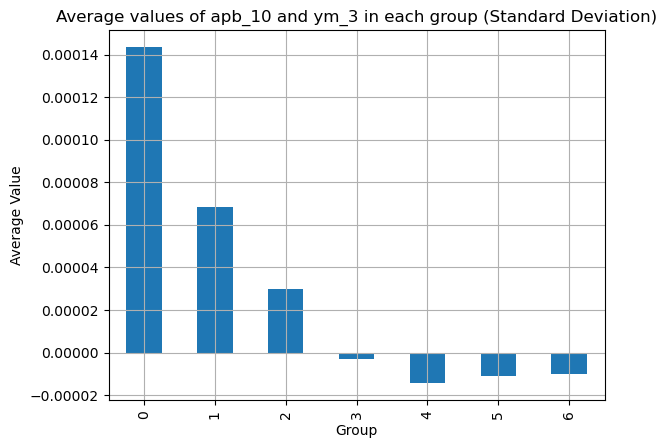

    group_std    apb_10      ym_3
0   -∞ to -3σ -0.164925  0.000144
1  -3σ to -2σ -0.091594  0.000068
2   -2σ to -σ -0.052402  0.000030
3    -σ to +σ -0.000699 -0.000003
4   +σ to +2σ  0.054205 -0.000014
5  +2σ to +3σ  0.094341 -0.000011
6   +3σ to +∞  0.170419 -0.000010


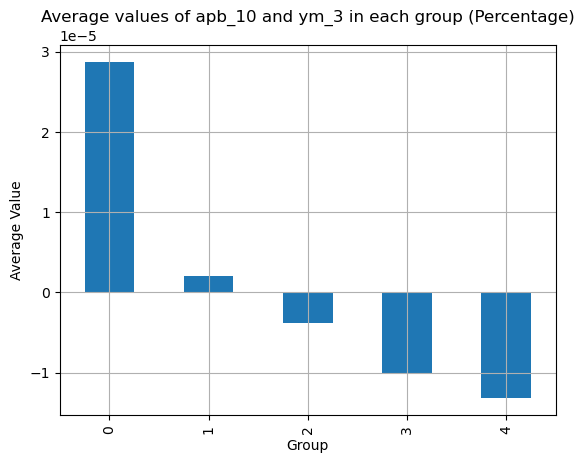

  group_percent    apb_10      ym_3
0         0-20% -0.046815  0.000029
1        20-40% -0.011261  0.000002
2        40-60% -0.000961 -0.000004
3        60-80%  0.009795 -0.000010
4       80-100%  0.048275 -0.000013


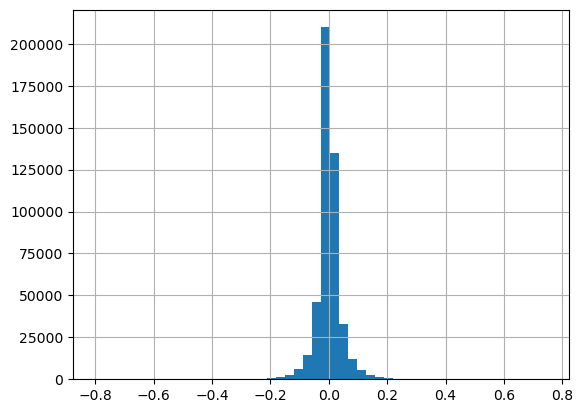

-0.7986604136033357 7.262976531457396e-05 0.7452019975310002


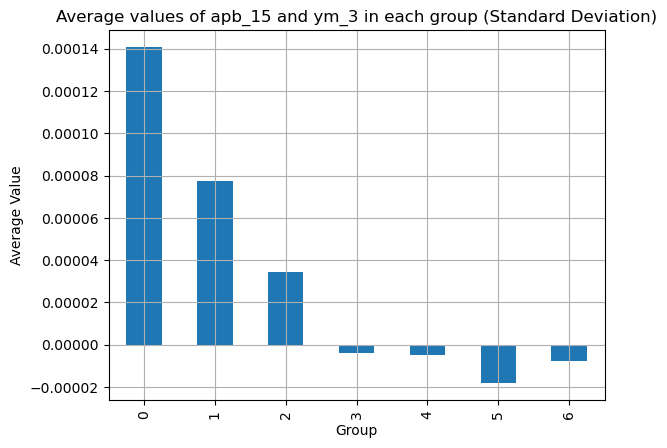

    group_std    apb_15      ym_3
0   -∞ to -3σ -0.187594  0.000141
1  -3σ to -2σ -0.104121  0.000078
2   -2σ to -σ -0.060092  0.000034
3    -σ to +σ -0.000356 -0.000004
4   +σ to +2σ  0.062040 -0.000005
5  +2σ to +3σ  0.106417 -0.000018
6   +3σ to +∞  0.189708 -0.000008


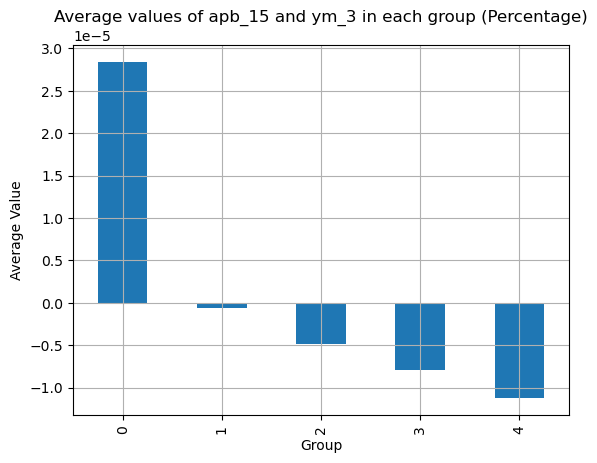

  group_percent    apb_15          ym_3
0         0-20% -0.053776  2.839331e-05
1        20-40% -0.012559 -5.680896e-07
2        40-60% -0.000590 -4.848644e-06
3        60-80%  0.011856 -7.897843e-06
4       80-100%  0.055037 -1.123963e-05


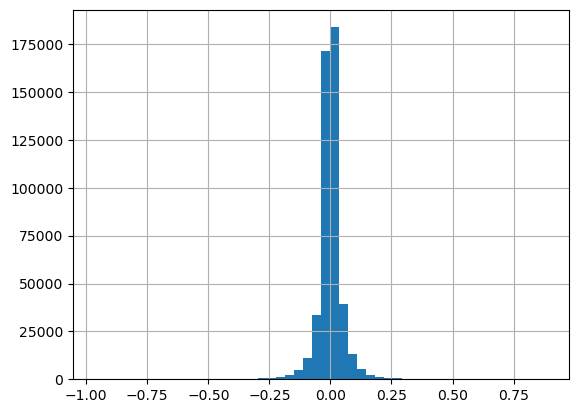

-0.9619318849965881 0.00010131855367300731 0.8846344351443753


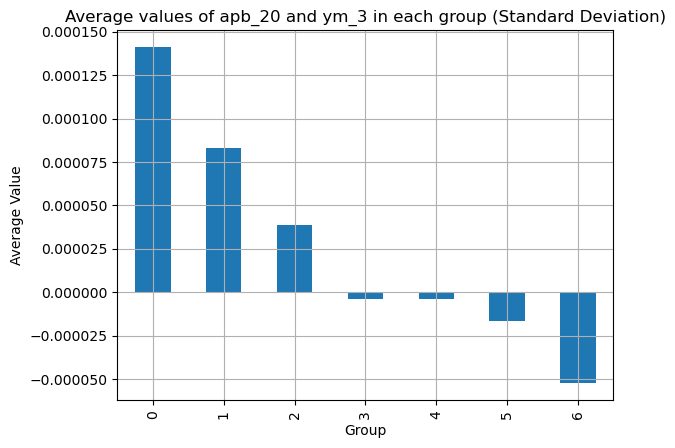

    group_std    apb_20      ym_3
0   -∞ to -3σ -0.209281  0.000141
1  -3σ to -2σ -0.114832  0.000083
2   -2σ to -σ -0.066754  0.000039
3    -σ to +σ -0.000171 -0.000004
4   +σ to +2σ  0.068812 -0.000004
5  +2σ to +3σ  0.117311 -0.000017
6   +3σ to +∞  0.205303 -0.000052


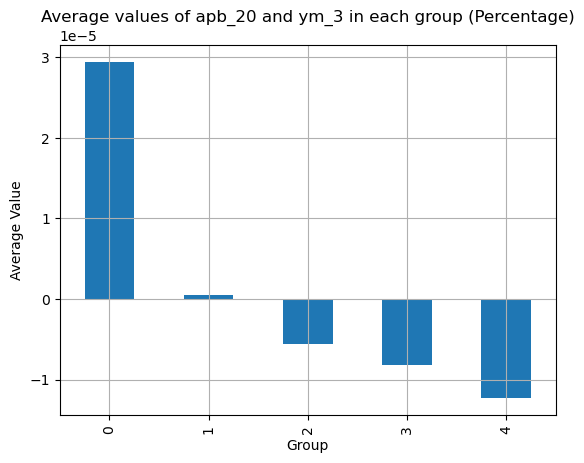

  group_percent    apb_20          ym_3
0         0-20% -0.060318  2.939672e-05
1        20-40% -0.013805  5.377738e-07
2        40-60% -0.000400 -5.555635e-06
3        60-80%  0.013556 -8.216034e-06
4       80-100%  0.061060 -1.227715e-05


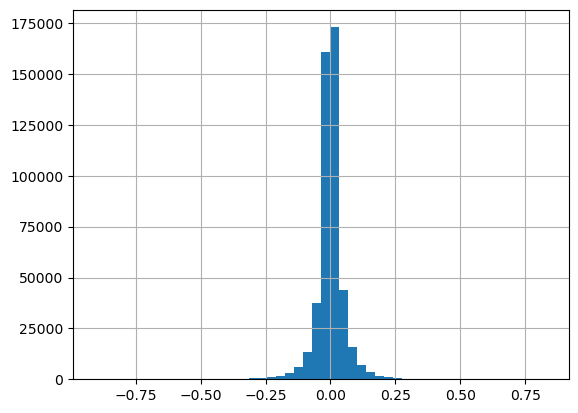

-0.9047989639133244 6.051453736155285e-06 0.831899703390613


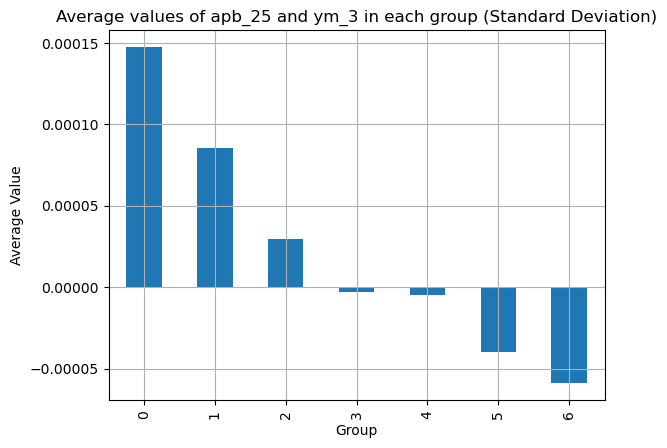

    group_std    apb_25      ym_3
0   -∞ to -3σ -0.231008  0.000148
1  -3σ to -2σ -0.126451  0.000086
2   -2σ to -σ -0.072926  0.000030
3    -σ to +σ -0.000009 -0.000003
4   +σ to +2σ  0.074934 -0.000005
5  +2σ to +3σ  0.128602 -0.000040
6   +3σ to +∞  0.218890 -0.000059


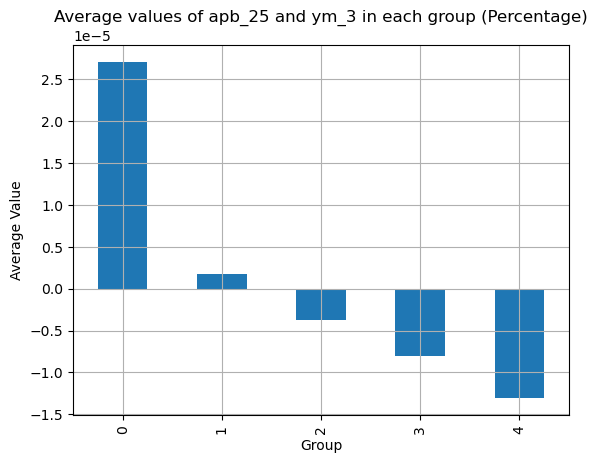

  group_percent    apb_25      ym_3
0         0-20% -0.066490  0.000027
1        20-40% -0.015012  0.000002
2        40-60% -0.000257 -0.000004
3        60-80%  0.015099 -0.000008
4       80-100%  0.066427 -0.000013


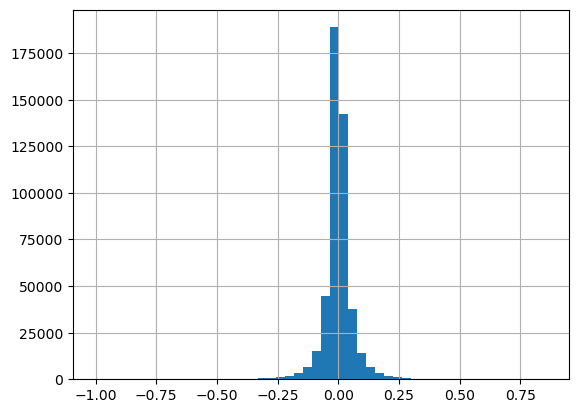

-1.0 -0.00014580826002696343 0.8581316035750737


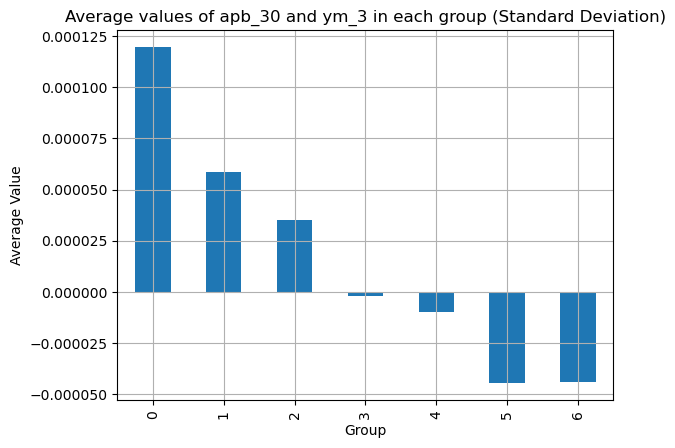

    group_std    apb_30      ym_3
0   -∞ to -3σ -0.254177  0.000120
1  -3σ to -2σ -0.136702  0.000059
2   -2σ to -σ -0.078929  0.000035
3    -σ to +σ  0.000061 -0.000002
4   +σ to +2σ  0.081394 -0.000010
5  +2σ to +3σ  0.139392 -0.000045
6   +3σ to +∞  0.231666 -0.000044


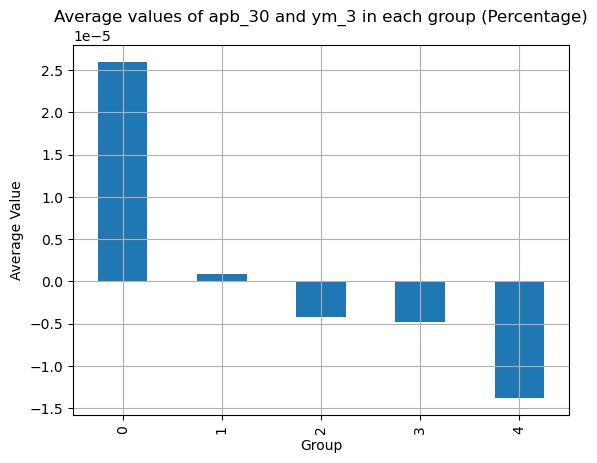

  group_percent    apb_30          ym_3
0         0-20% -0.072477  2.595842e-05
1        20-40% -0.016198  8.130361e-07
2        40-60% -0.000121 -4.195298e-06
3        60-80%  0.016467 -4.761334e-06
4       80-100%  0.071427 -1.381602e-05


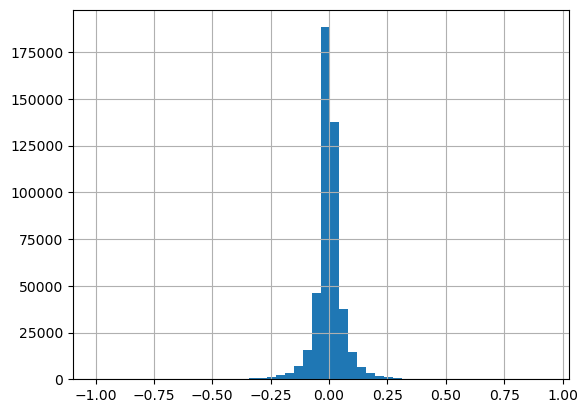

-1.0 -0.0003317603764142349 0.9310959482043433


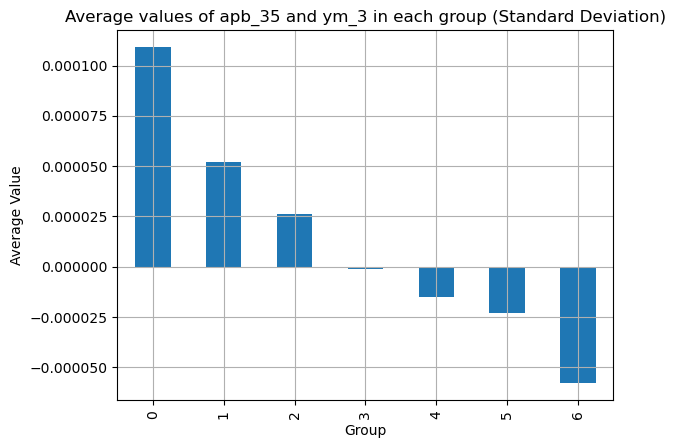

    group_std    apb_35      ym_3
0   -∞ to -3σ -0.275645  0.000109
1  -3σ to -2σ -0.146133  0.000052
2   -2σ to -σ -0.084656  0.000026
3    -σ to +σ  0.000181 -0.000001
4   +σ to +2σ  0.087692 -0.000015
5  +2σ to +3σ  0.149213 -0.000023
6   +3σ to +∞  0.245160 -0.000058


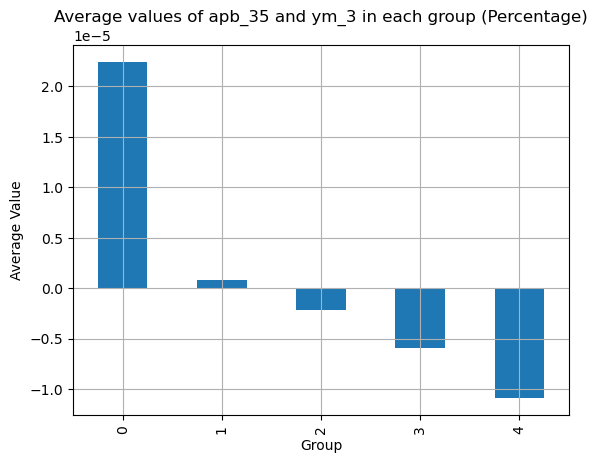

  group_percent    apb_35          ym_3
0         0-20% -0.078372  2.240559e-05
1        20-40% -0.017328  7.914416e-07
2        40-60% -0.000025 -2.197517e-06
3        60-80%  0.017940 -5.895553e-06
4       80-100%  0.076304 -1.087877e-05


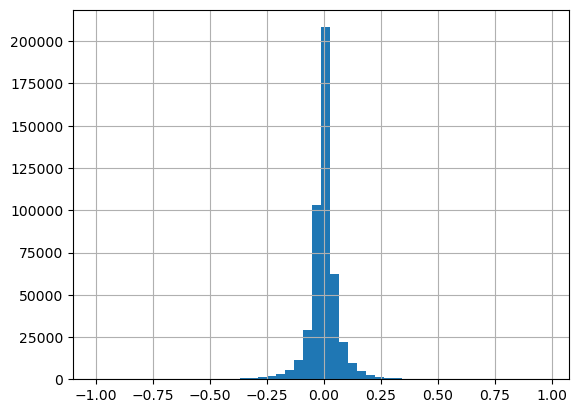

-1.0 -0.0005410768761350124 0.9753397497841649


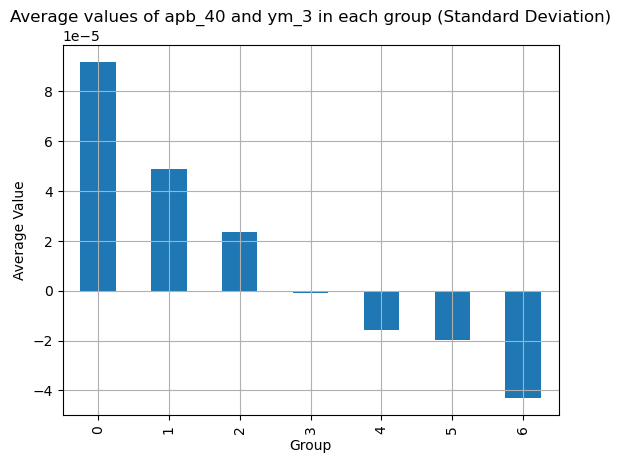

    group_std    apb_40          ym_3
0   -∞ to -3σ -0.296976  9.170781e-05
1  -3σ to -2σ -0.155774  4.891814e-05
2   -2σ to -σ -0.090593  2.348475e-05
3    -σ to +σ  0.000409 -7.902404e-07
4   +σ to +2σ  0.093848 -1.572213e-05
5  +2σ to +3σ  0.160018 -1.962700e-05
6   +3σ to +∞  0.260471 -4.306847e-05


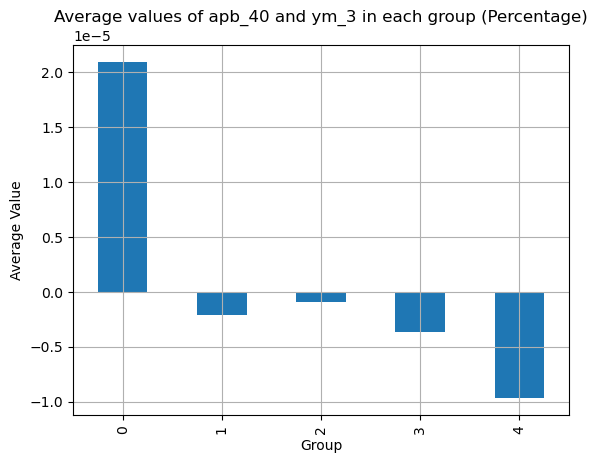

  group_percent    apb_40          ym_3
0         0-20% -0.084265  2.091377e-05
1        20-40% -0.018521 -2.096430e-06
2        40-60%  0.000088 -9.359736e-07
3        60-80%  0.019323 -3.615282e-06
4       80-100%  0.080849 -9.670559e-06


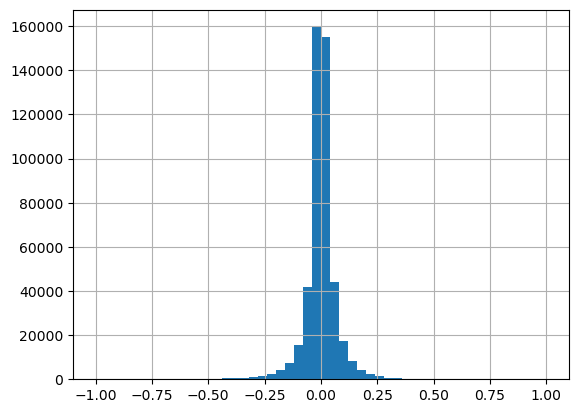

-1.0 -0.000760587144849705 1.0


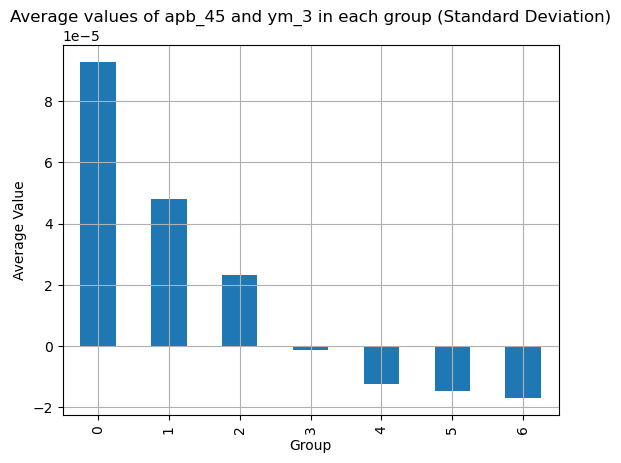

    group_std    apb_45      ym_3
0   -∞ to -3σ -0.314835  0.000093
1  -3σ to -2σ -0.165721  0.000048
2   -2σ to -σ -0.095712  0.000023
3    -σ to +σ  0.000588 -0.000001
4   +σ to +2σ  0.099386 -0.000012
5  +2σ to +3σ  0.169622 -0.000015
6   +3σ to +∞  0.272592 -0.000017


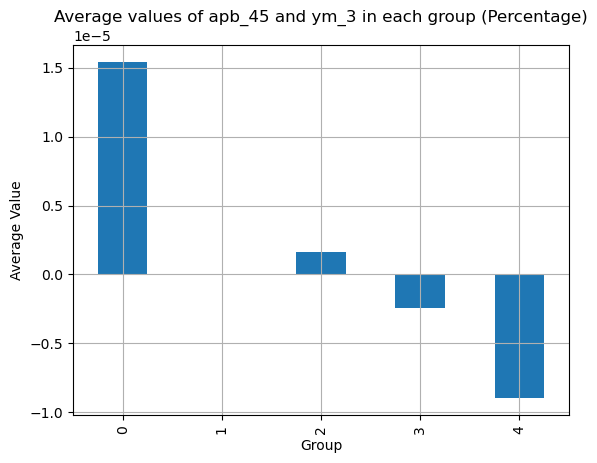

  group_percent    apb_45          ym_3
0         0-20% -0.089653  1.540759e-05
1        20-40% -0.019680 -5.335765e-08
2        40-60%  0.000195  1.624375e-06
3        60-80%  0.020678 -2.399357e-06
4       80-100%  0.084924 -8.966218e-06


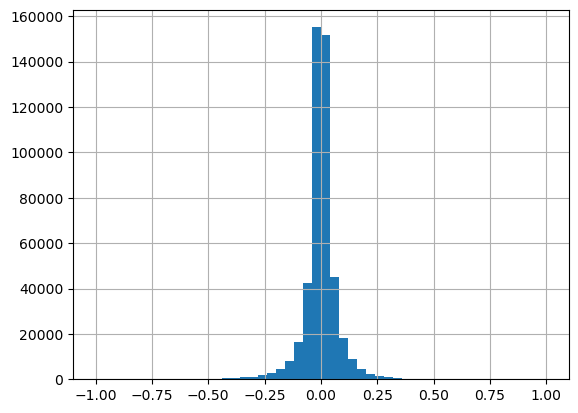

-1.0 -0.0009898968271137786 1.0


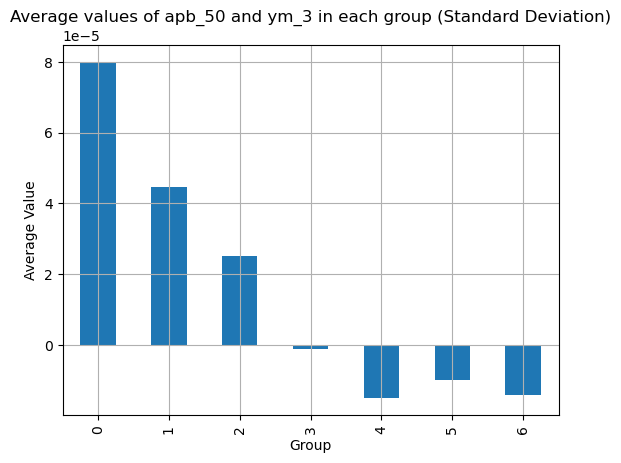

    group_std    apb_50      ym_3
0   -∞ to -3σ -0.330865  0.000080
1  -3σ to -2σ -0.177481  0.000045
2   -2σ to -σ -0.100889  0.000025
3    -σ to +σ  0.000824 -0.000001
4   +σ to +2σ  0.104896 -0.000015
5  +2σ to +3σ  0.178227 -0.000010
6   +3σ to +∞  0.286079 -0.000014


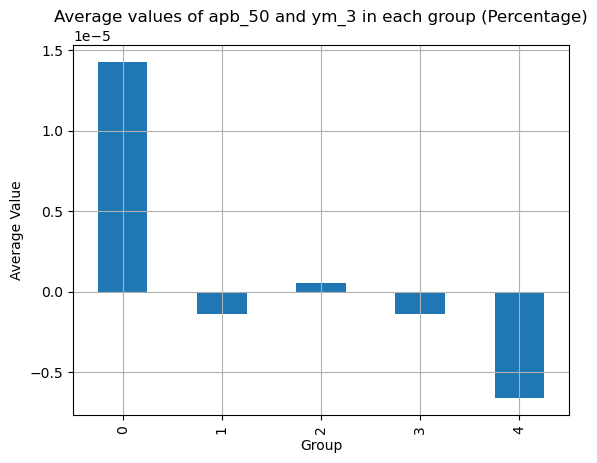

  group_percent    apb_50          ym_3
0         0-20% -0.094841  1.425701e-05
1        20-40% -0.020818 -1.390046e-06
2        40-60%  0.000377  5.554459e-07
3        60-80%  0.021895 -1.401388e-06
4       80-100%  0.088586 -6.606091e-06


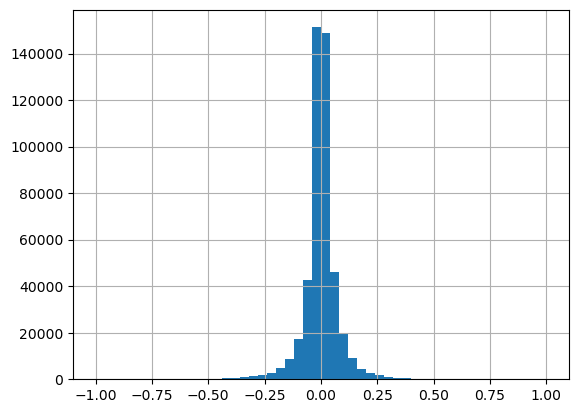

-1.0 -0.0012296730195210002 1.0


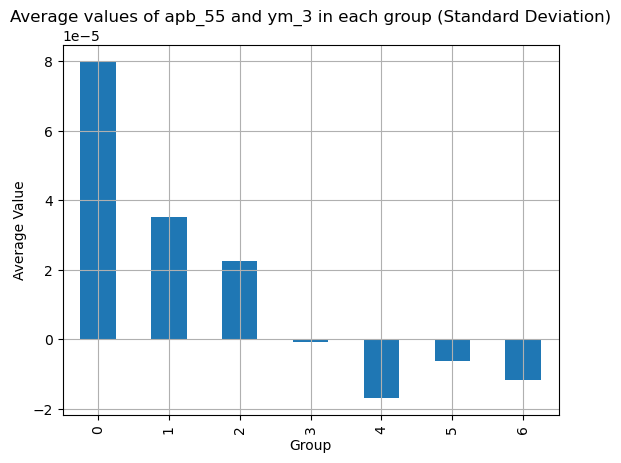

    group_std    apb_55          ym_3
0   -∞ to -3σ -0.347421  7.978949e-05
1  -3σ to -2σ -0.185288  3.515338e-05
2   -2σ to -σ -0.105314  2.249282e-05
3    -σ to +σ  0.001086 -7.680929e-07
4   +σ to +2σ  0.109533 -1.690094e-05
5  +2σ to +3σ  0.185514 -6.371074e-06
6   +3σ to +∞  0.298783 -1.166144e-05


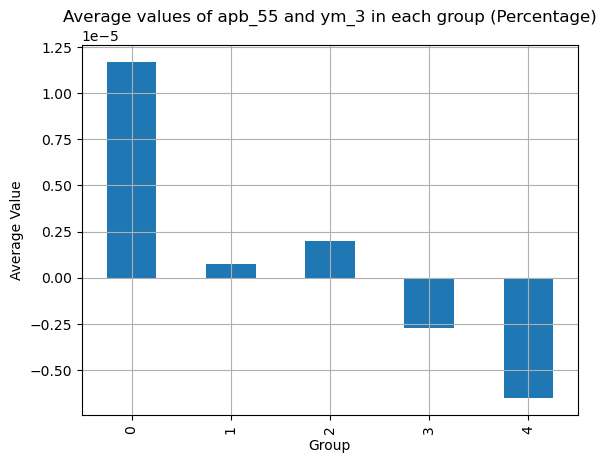

  group_percent    apb_55          ym_3
0         0-20% -0.099819  1.168790e-05
1        20-40% -0.021756  7.419067e-07
2        40-60%  0.000535  1.994750e-06
3        60-80%  0.023099 -2.706609e-06
4       80-100%  0.091992 -6.525366e-06


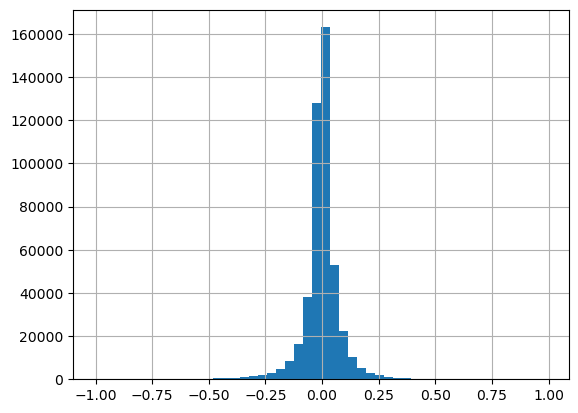

-1.0 -0.001473219594415568 0.990701144631501


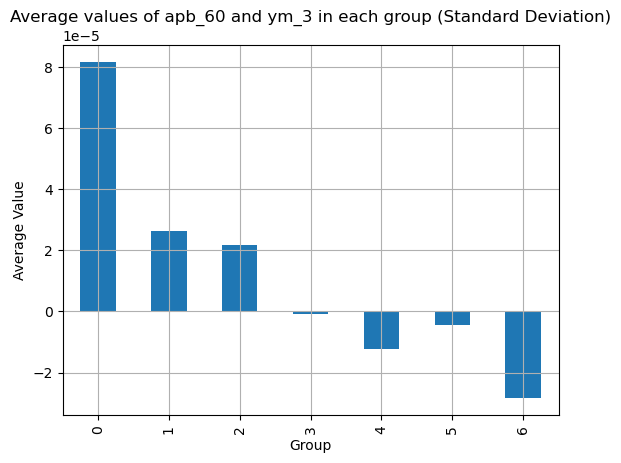

    group_std    apb_60          ym_3
0   -∞ to -3σ -0.361838  8.160626e-05
1  -3σ to -2σ -0.193391  2.630370e-05
2   -2σ to -σ -0.109765  2.180567e-05
3    -σ to +σ  0.001240 -9.015459e-07
4   +σ to +2σ  0.114094 -1.233313e-05
5  +2σ to +3σ  0.191354 -4.514409e-06
6   +3σ to +∞  0.311918 -2.834214e-05


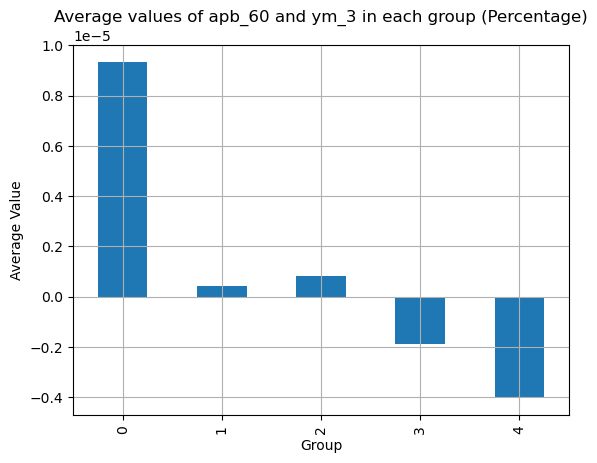

  group_percent    apb_60          ym_3
0         0-20% -0.104740  9.336437e-06
1        20-40% -0.022743  4.203726e-07
2        40-60%  0.000613  8.389311e-07
3        60-80%  0.024301 -1.877771e-06
4       80-100%  0.095081 -4.030317e-06


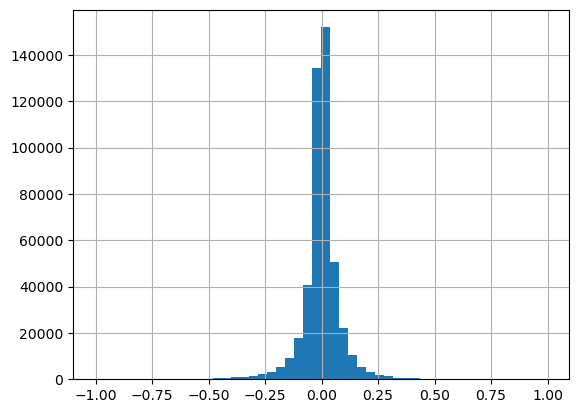

-1.0 -0.0017176472514979211 0.9951620300777038


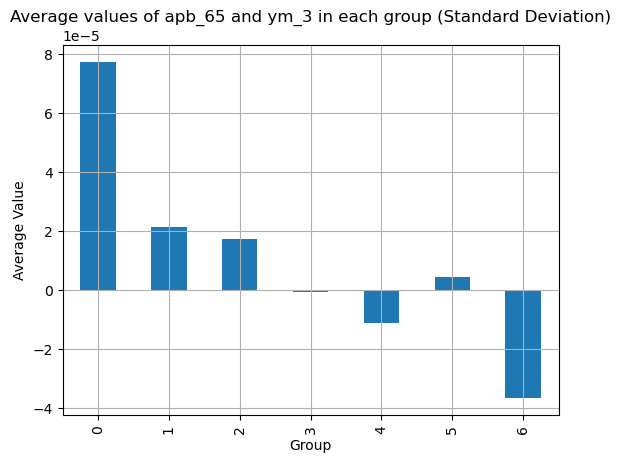

    group_std    apb_65          ym_3
0   -∞ to -3σ -0.373623  7.734701e-05
1  -3σ to -2σ -0.202057  2.124890e-05
2   -2σ to -σ -0.114114  1.717156e-05
3    -σ to +σ  0.001382 -6.106644e-07
4   +σ to +2σ  0.118464 -1.132118e-05
5  +2σ to +3σ  0.196821  4.485999e-06
6   +3σ to +∞  0.323385 -3.666374e-05


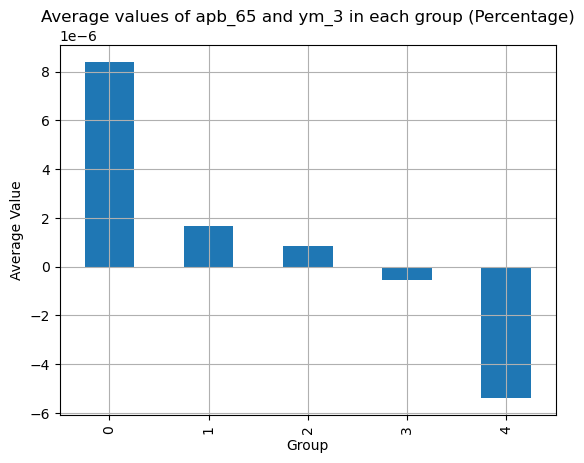

  group_percent    apb_65          ym_3
0         0-20% -0.109110  8.393593e-06
1        20-40% -0.023635  1.655872e-06
2        40-60%  0.000662  8.515846e-07
3        60-80%  0.025378 -5.647149e-07
4       80-100%  0.098138 -5.385977e-06


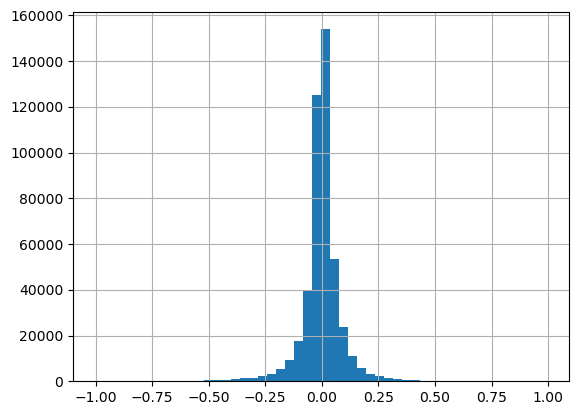

-1.0 -0.0019597870070279127 0.9919606332287461


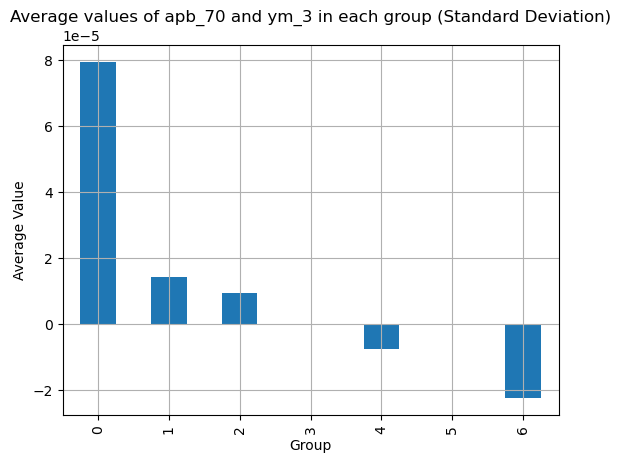

    group_std    apb_70          ym_3
0   -∞ to -3σ -0.386795  7.943526e-05
1  -3σ to -2σ -0.209739  1.422339e-05
2   -2σ to -σ -0.118588  9.448472e-06
3    -σ to +σ  0.001493 -1.829545e-07
4   +σ to +2σ  0.122827 -7.615794e-06
5  +2σ to +3σ  0.202473 -4.624544e-07
6   +3σ to +∞  0.335035 -2.247790e-05


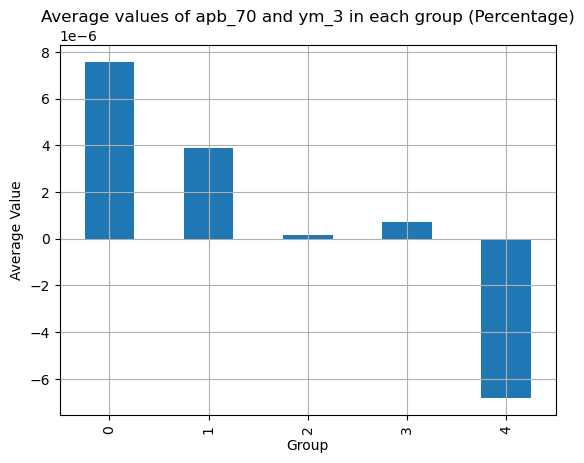

  group_percent    apb_70          ym_3
0         0-20% -0.113336  7.561684e-06
1        20-40% -0.024476  3.867334e-06
2        40-60%  0.000760  1.541163e-07
3        60-80%  0.026533  7.227941e-07
4       80-100%  0.101114 -6.822062e-06


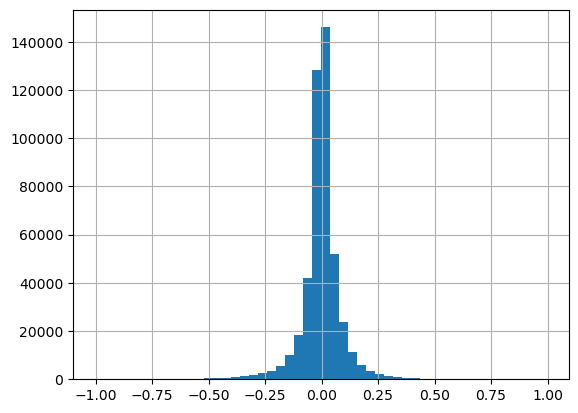

-1.0 -0.002205834099859749 0.9951785220404228


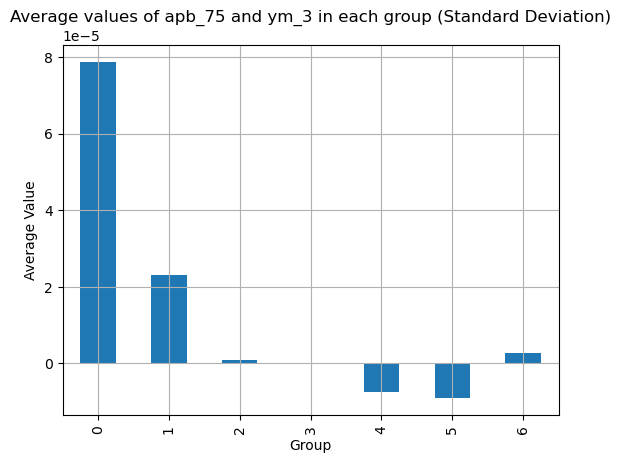

    group_std    apb_75          ym_3
0   -∞ to -3σ -0.400218  7.864210e-05
1  -3σ to -2σ -0.216635  2.300158e-05
2   -2σ to -σ -0.123339  8.935815e-07
3    -σ to +σ  0.001549  1.864649e-07
4   +σ to +2σ  0.126420 -7.438421e-06
5  +2σ to +3σ  0.209681 -9.019421e-06
6   +3σ to +∞  0.343488  2.716901e-06


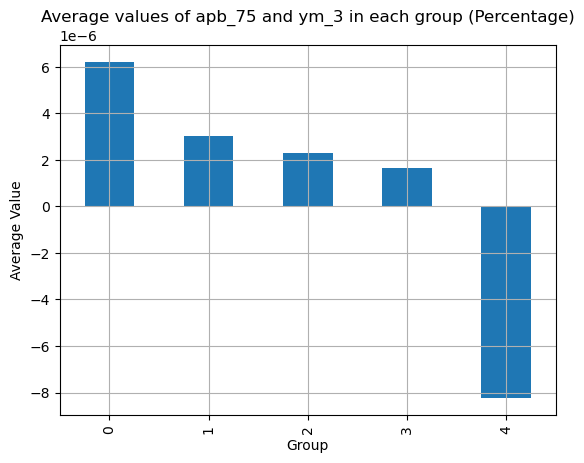

  group_percent    apb_75      ym_3
0         0-20% -0.117398  0.000006
1        20-40% -0.025311  0.000003
2        40-60%  0.000915  0.000002
3        60-80%  0.027717  0.000002
4       80-100%  0.104184 -0.000008


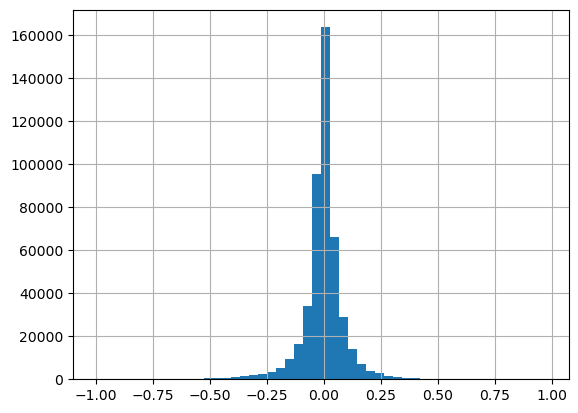

-1.0 -0.00245744062209518 0.9763695356909796


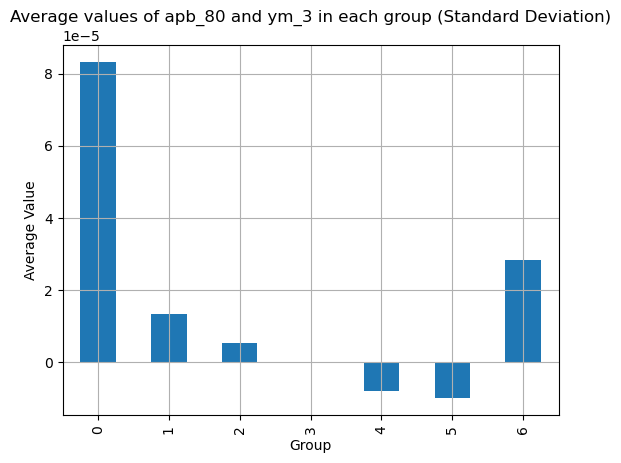

    group_std    apb_80          ym_3
0   -∞ to -3σ -0.412751  8.318004e-05
1  -3σ to -2σ -0.224565  1.324958e-05
2   -2σ to -σ -0.127770  5.248867e-06
3    -σ to +σ  0.001683 -1.502387e-07
4   +σ to +2σ  0.130726 -8.175612e-06
5  +2σ to +3σ  0.216237 -9.999521e-06
6   +3σ to +∞  0.350428  2.824389e-05


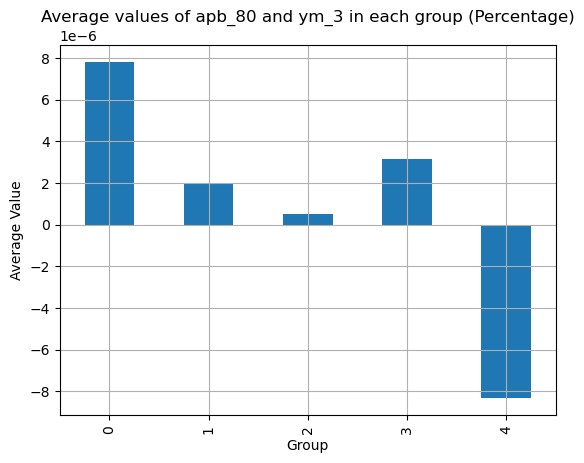

  group_percent    apb_80          ym_3
0         0-20% -0.121523  7.809246e-06
1        20-40% -0.026186  1.953385e-06
2        40-60%  0.000974  5.084850e-07
3        60-80%  0.028829  3.167893e-06
4       80-100%  0.107353 -8.318572e-06


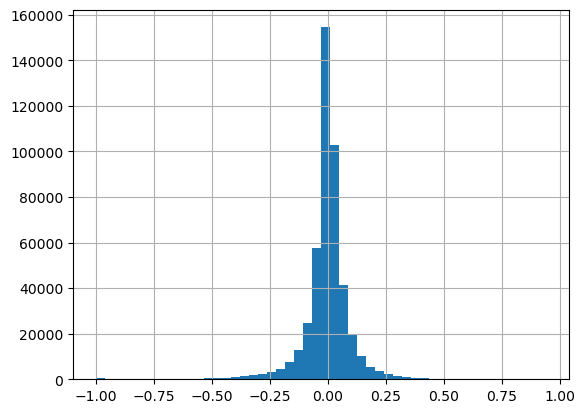

-1.0 -0.002706129804961806 0.9425572535211395


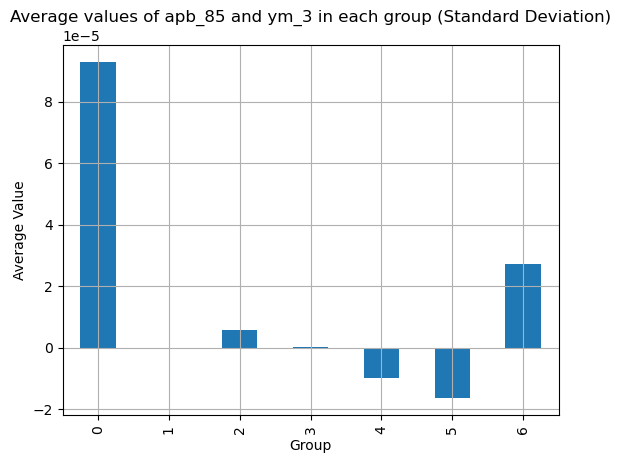

    group_std    apb_85          ym_3
0   -∞ to -3σ -0.422591  9.284724e-05
1  -3σ to -2σ -0.234127 -3.419133e-07
2   -2σ to -σ -0.131692  5.646138e-06
3    -σ to +σ  0.001901  2.719343e-07
4   +σ to +2σ  0.135210 -9.862595e-06
5  +2σ to +3σ  0.221959 -1.641778e-05
6   +3σ to +∞  0.360205  2.731606e-05


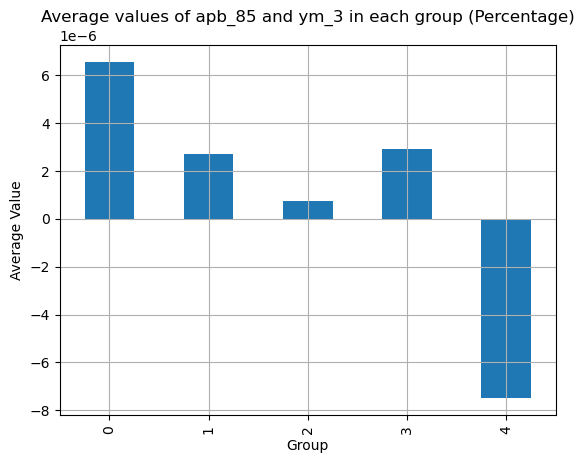

  group_percent    apb_85          ym_3
0         0-20% -0.125182  6.539653e-06
1        20-40% -0.027058  2.715265e-06
2        40-60%  0.001061  7.396543e-07
3        60-80%  0.029704  2.921234e-06
4       80-100%  0.110247 -7.483636e-06


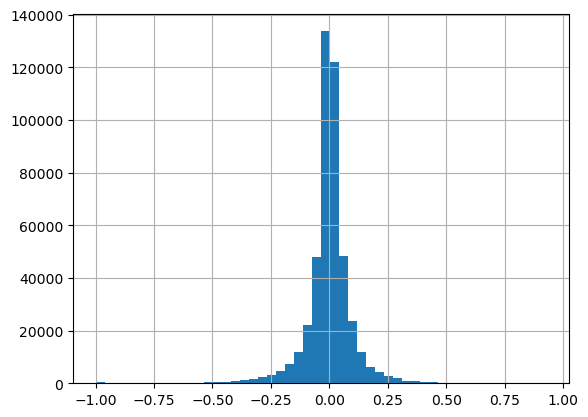

-1.0 -0.0029532566884387865 0.9281867852819567


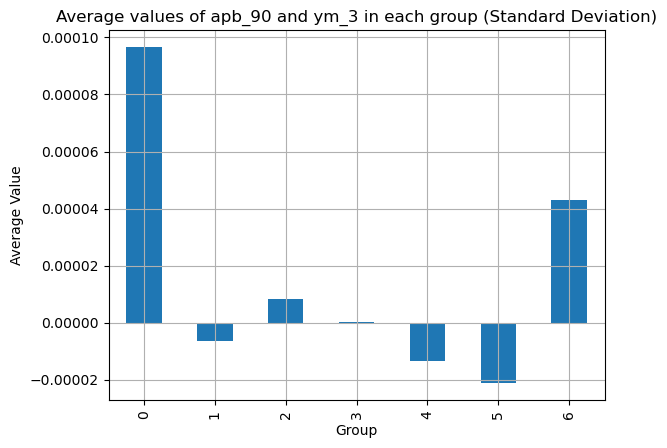

    group_std    apb_90          ym_3
0   -∞ to -3σ -0.433420  9.662097e-05
1  -3σ to -2σ -0.239886 -6.361280e-06
2   -2σ to -σ -0.136290  8.369178e-06
3    -σ to +σ  0.002051  2.042129e-07
4   +σ to +2σ  0.139138 -1.354194e-05
5  +2σ to +3σ  0.226505 -2.116278e-05
6   +3σ to +∞  0.374921  4.291511e-05


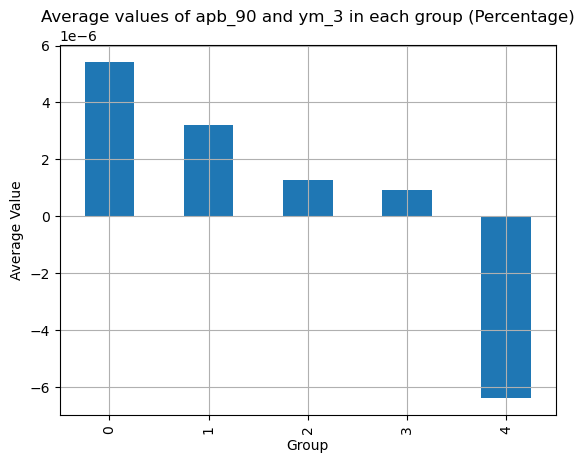

  group_percent    apb_90          ym_3
0         0-20% -0.129074  5.420252e-06
1        20-40% -0.027956  3.203726e-06
2        40-60%  0.001192  1.283817e-06
3        60-80%  0.030565  9.317318e-07
4       80-100%  0.113190 -6.391523e-06


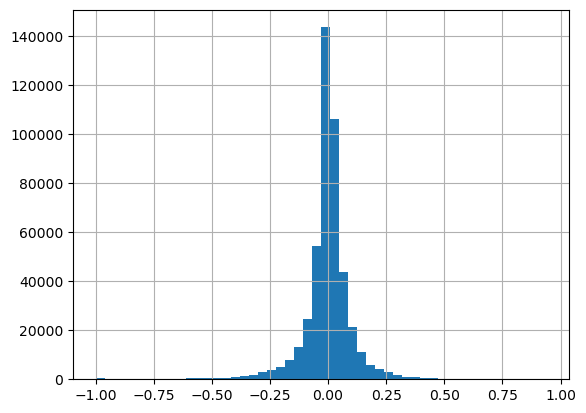

-1.0 -0.003200488949275717 0.9389617502723044


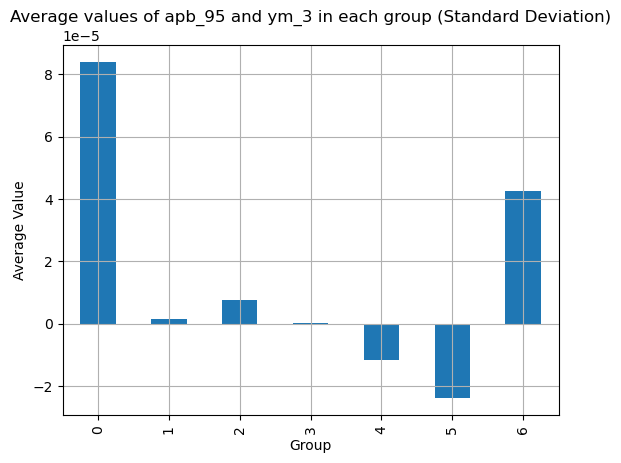

    group_std    apb_95          ym_3
0   -∞ to -3σ -0.445328  8.389057e-05
1  -3σ to -2σ -0.244489  1.612467e-06
2   -2σ to -σ -0.140401  7.698339e-06
3    -σ to +σ  0.002177  2.885089e-07
4   +σ to +2σ  0.143179 -1.167509e-05
5  +2σ to +3σ  0.229960 -2.388053e-05
6   +3σ to +∞  0.391026  4.249153e-05


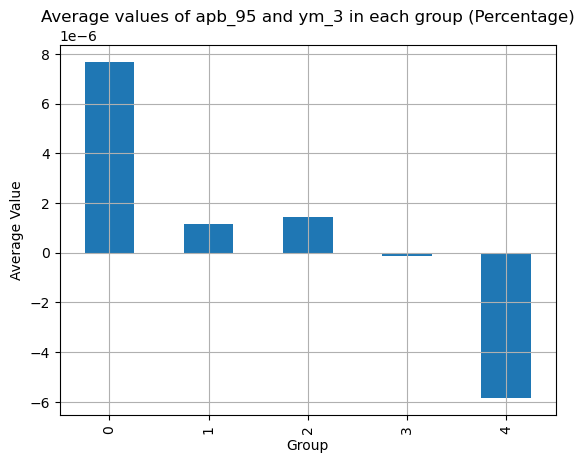

  group_percent    apb_95          ym_3
0         0-20% -0.132532  7.671451e-06
1        20-40% -0.028890  1.145156e-06
2        40-60%  0.001253  1.423865e-06
3        60-80%  0.031431 -1.379790e-07
4       80-100%  0.115516 -5.845729e-06


In [19]:
for back_ticks in range(10, 100, 5):
    assess_apb_wrt_return(data, back_ticks, 'ym_3')

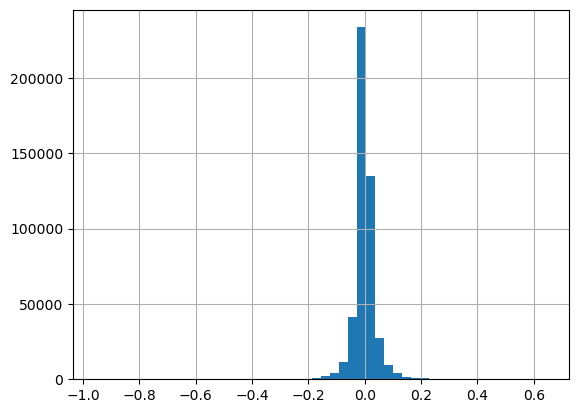

-0.9559484420865437 -0.00016863496419868584 0.6447316929333218


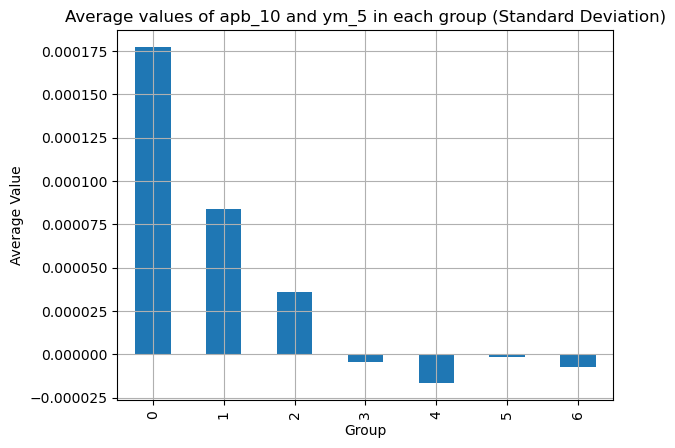

    group_std    apb_10      ym_5
0   -∞ to -3σ -0.164925  0.000177
1  -3σ to -2σ -0.091594  0.000084
2   -2σ to -σ -0.052402  0.000036
3    -σ to +σ -0.000699 -0.000005
4   +σ to +2σ  0.054205 -0.000017
5  +2σ to +3σ  0.094341 -0.000001
6   +3σ to +∞  0.170419 -0.000007


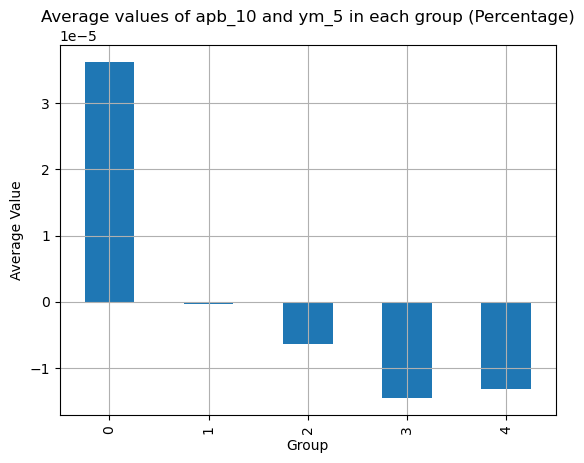

  group_percent    apb_10          ym_5
0         0-20% -0.046815  3.621731e-05
1        20-40% -0.011261 -3.674781e-07
2        40-60% -0.000961 -6.449995e-06
3        60-80%  0.009795 -1.455510e-05
4       80-100%  0.048275 -1.312444e-05


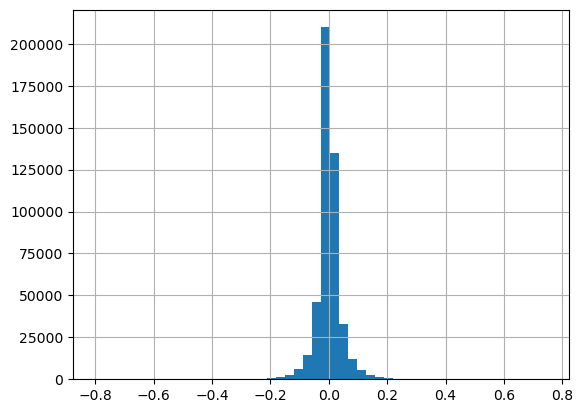

-0.7986604136033357 7.262976531457396e-05 0.7452019975310002


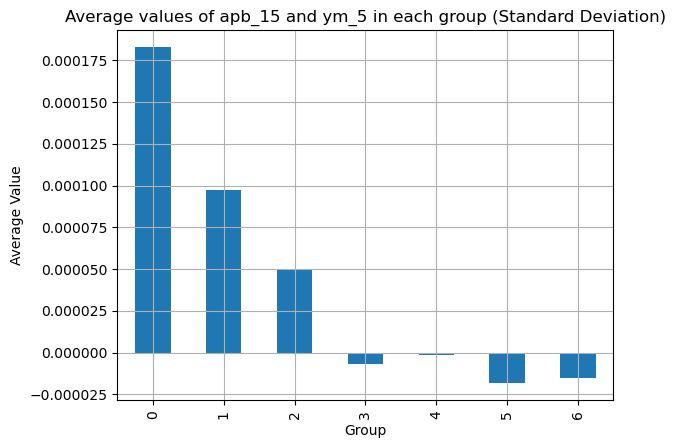

    group_std    apb_15      ym_5
0   -∞ to -3σ -0.187594  0.000183
1  -3σ to -2σ -0.104121  0.000098
2   -2σ to -σ -0.060092  0.000050
3    -σ to +σ -0.000356 -0.000007
4   +σ to +2σ  0.062040 -0.000001
5  +2σ to +3σ  0.106417 -0.000018
6   +3σ to +∞  0.189708 -0.000015


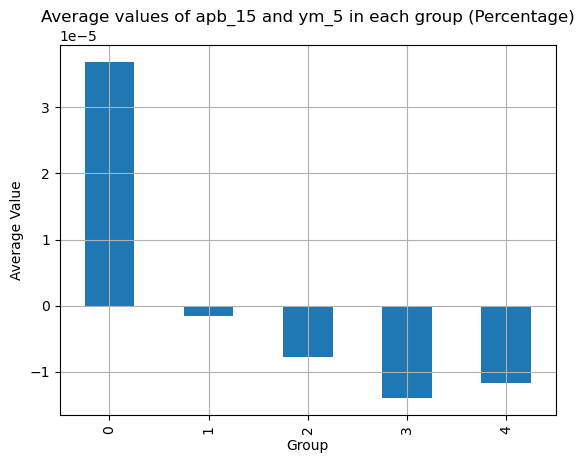

  group_percent    apb_15      ym_5
0         0-20% -0.053776  0.000037
1        20-40% -0.012559 -0.000002
2        40-60% -0.000590 -0.000008
3        60-80%  0.011856 -0.000014
4       80-100%  0.055037 -0.000012


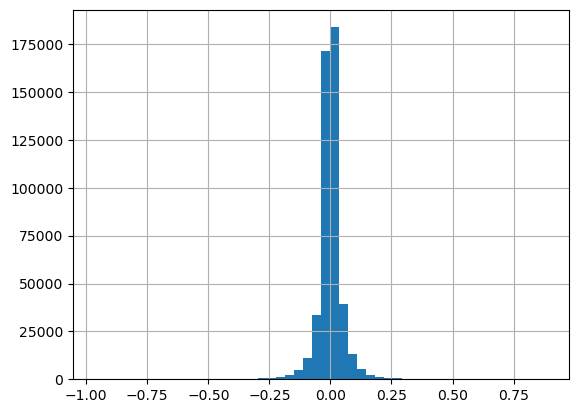

-0.9619318849965881 0.00010131855367300731 0.8846344351443753


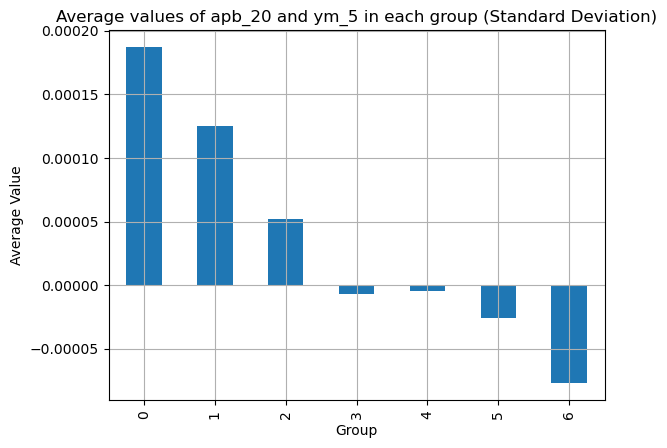

    group_std    apb_20      ym_5
0   -∞ to -3σ -0.209281  0.000187
1  -3σ to -2σ -0.114832  0.000126
2   -2σ to -σ -0.066754  0.000052
3    -σ to +σ -0.000171 -0.000007
4   +σ to +2σ  0.068812 -0.000004
5  +2σ to +3σ  0.117311 -0.000025
6   +3σ to +∞  0.205303 -0.000077


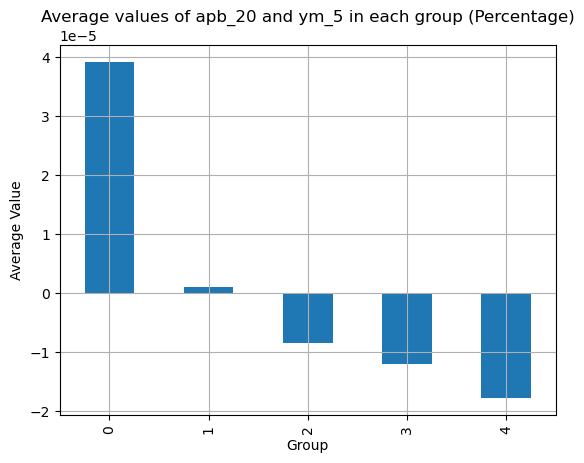

  group_percent    apb_20      ym_5
0         0-20% -0.060318  0.000039
1        20-40% -0.013805  0.000001
2        40-60% -0.000400 -0.000008
3        60-80%  0.013556 -0.000012
4       80-100%  0.061060 -0.000018


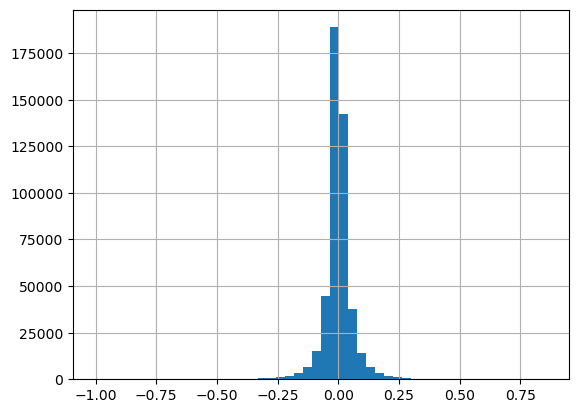

-1.0 -0.00014580826002696343 0.8581316035750737


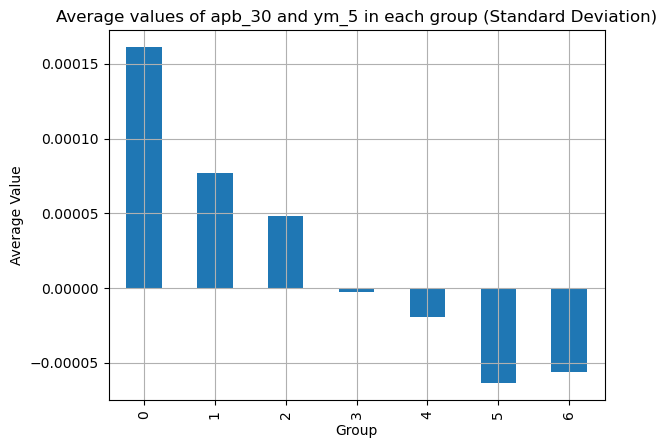

    group_std    apb_30      ym_5
0   -∞ to -3σ -0.254177  0.000161
1  -3σ to -2σ -0.136702  0.000077
2   -2σ to -σ -0.078929  0.000048
3    -σ to +σ  0.000061 -0.000003
4   +σ to +2σ  0.081394 -0.000019
5  +2σ to +3σ  0.139392 -0.000064
6   +3σ to +∞  0.231666 -0.000057


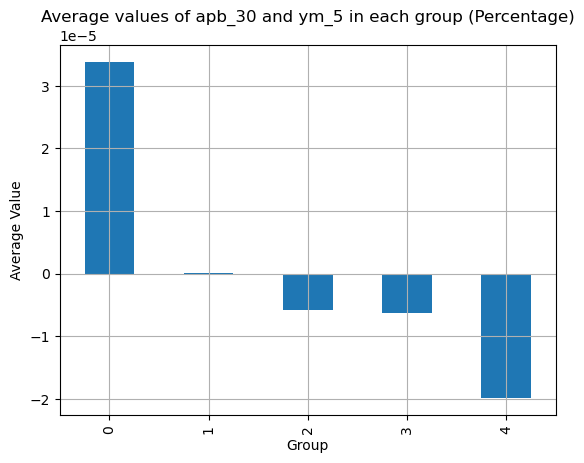

  group_percent    apb_30          ym_5
0         0-20% -0.072477  3.380738e-05
1        20-40% -0.016198  1.506433e-07
2        40-60% -0.000121 -5.779263e-06
3        60-80%  0.016467 -6.322070e-06
4       80-100%  0.071427 -1.987820e-05


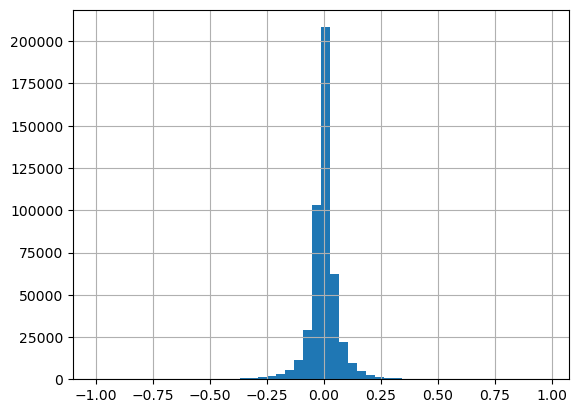

-1.0 -0.0005410768761350124 0.9753397497841649


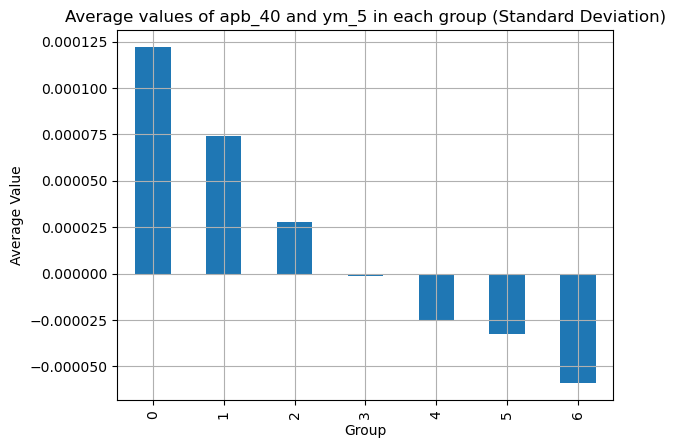

    group_std    apb_40      ym_5
0   -∞ to -3σ -0.296976  0.000122
1  -3σ to -2σ -0.155774  0.000074
2   -2σ to -σ -0.090593  0.000028
3    -σ to +σ  0.000409 -0.000001
4   +σ to +2σ  0.093848 -0.000025
5  +2σ to +3σ  0.160018 -0.000033
6   +3σ to +∞  0.260471 -0.000059


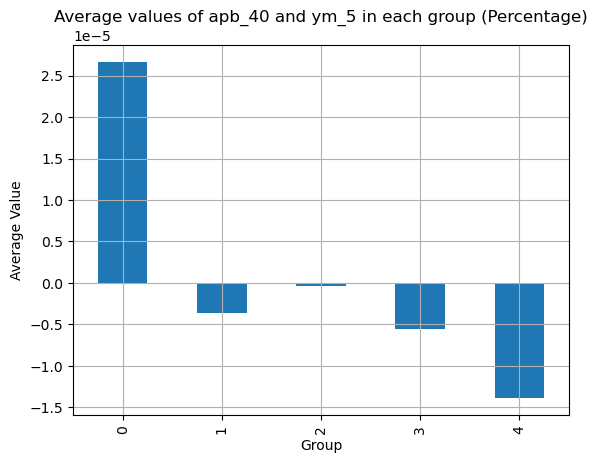

  group_percent    apb_40          ym_5
0         0-20% -0.084265  2.664426e-05
1        20-40% -0.018521 -3.579610e-06
2        40-60%  0.000088 -4.255879e-07
3        60-80%  0.019323 -5.597543e-06
4       80-100%  0.080849 -1.388654e-05


In [20]:
for back_ticks in [10, 15, 20, 30, 40]:
    assess_apb_wrt_return(data, back_ticks, 'ym_5')

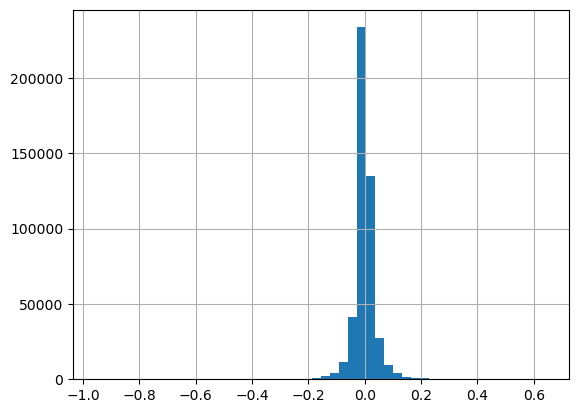

-0.9559484420865437 -0.00016863496419868584 0.6447316929333218


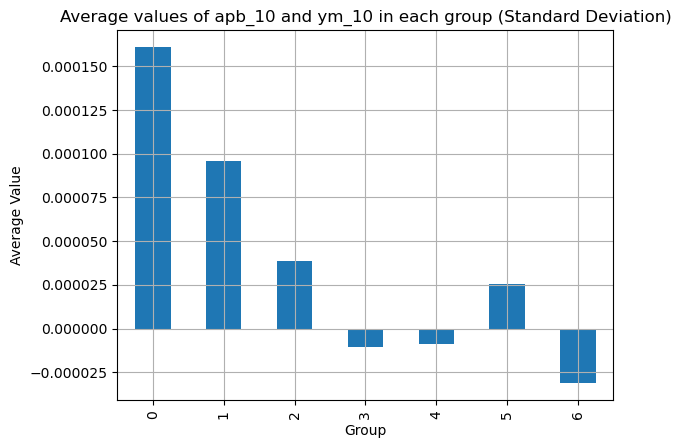

    group_std    apb_10     ym_10
0   -∞ to -3σ -0.164925  0.000161
1  -3σ to -2σ -0.091594  0.000096
2   -2σ to -σ -0.052402  0.000039
3    -σ to +σ -0.000699 -0.000010
4   +σ to +2σ  0.054205 -0.000009
5  +2σ to +3σ  0.094341  0.000025
6   +3σ to +∞  0.170419 -0.000031


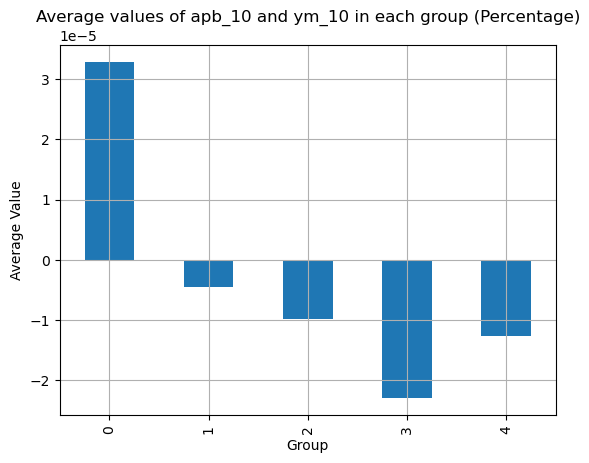

  group_percent    apb_10     ym_10
0         0-20% -0.046815  0.000033
1        20-40% -0.011261 -0.000004
2        40-60% -0.000961 -0.000010
3        60-80%  0.009795 -0.000023
4       80-100%  0.048275 -0.000013


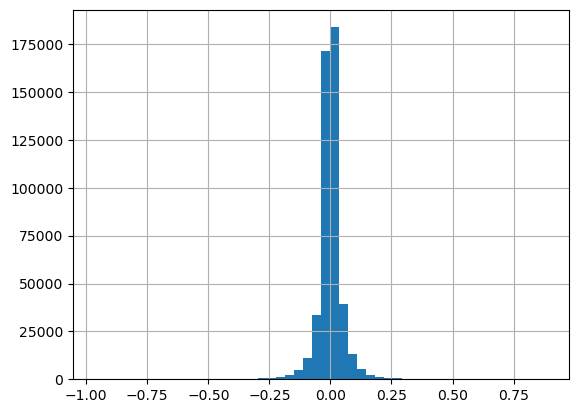

-0.9619318849965881 0.00010131855367300731 0.8846344351443753


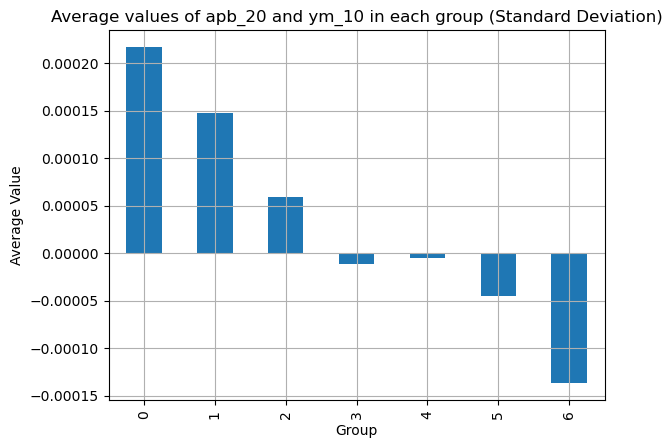

    group_std    apb_20     ym_10
0   -∞ to -3σ -0.209281  0.000217
1  -3σ to -2σ -0.114832  0.000147
2   -2σ to -σ -0.066754  0.000059
3    -σ to +σ -0.000171 -0.000011
4   +σ to +2σ  0.068812 -0.000005
5  +2σ to +3σ  0.117311 -0.000045
6   +3σ to +∞  0.205303 -0.000137


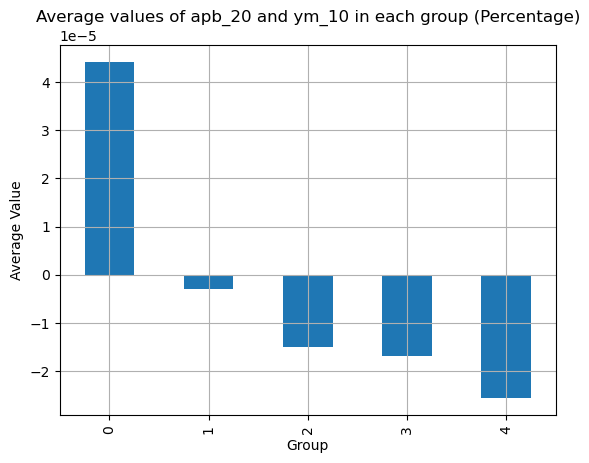

  group_percent    apb_20     ym_10
0         0-20% -0.060318  0.000044
1        20-40% -0.013805 -0.000003
2        40-60% -0.000400 -0.000015
3        60-80%  0.013556 -0.000017
4       80-100%  0.061060 -0.000026


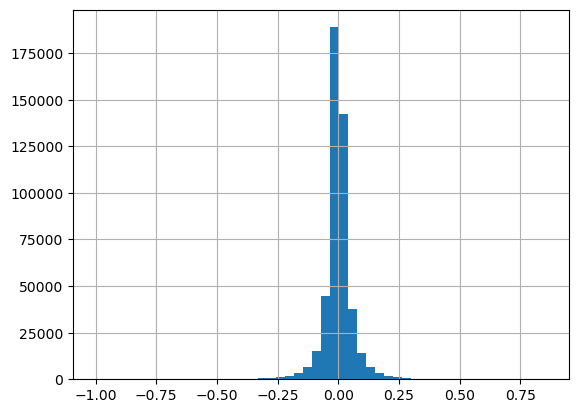

-1.0 -0.00014580826002696343 0.8581316035750737


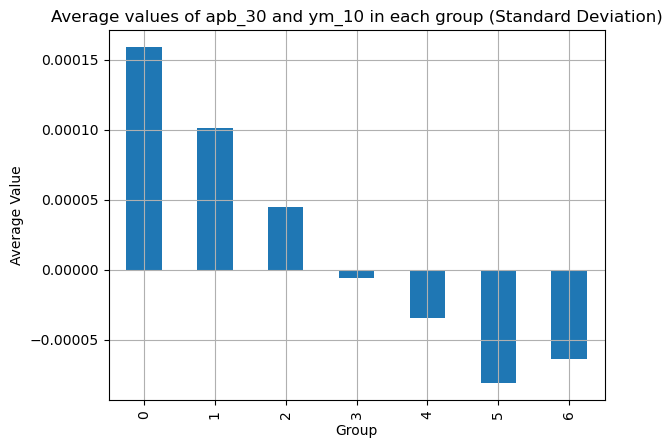

    group_std    apb_30     ym_10
0   -∞ to -3σ -0.254177  0.000159
1  -3σ to -2σ -0.136702  0.000101
2   -2σ to -σ -0.078929  0.000044
3    -σ to +σ  0.000061 -0.000006
4   +σ to +2σ  0.081394 -0.000034
5  +2σ to +3σ  0.139392 -0.000081
6   +3σ to +∞  0.231666 -0.000064


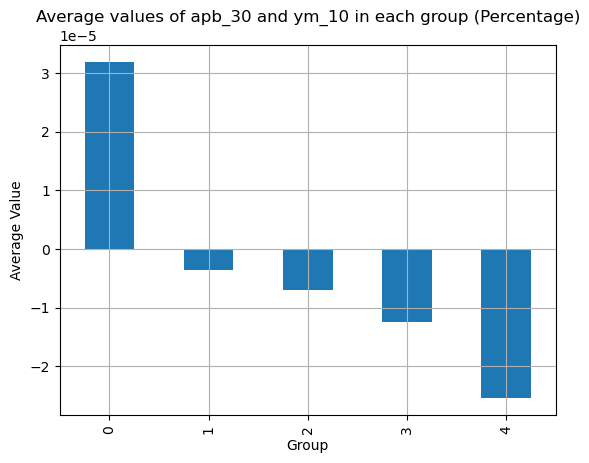

  group_percent    apb_30     ym_10
0         0-20% -0.072477  0.000032
1        20-40% -0.016198 -0.000004
2        40-60% -0.000121 -0.000007
3        60-80%  0.016467 -0.000012
4       80-100%  0.071427 -0.000025


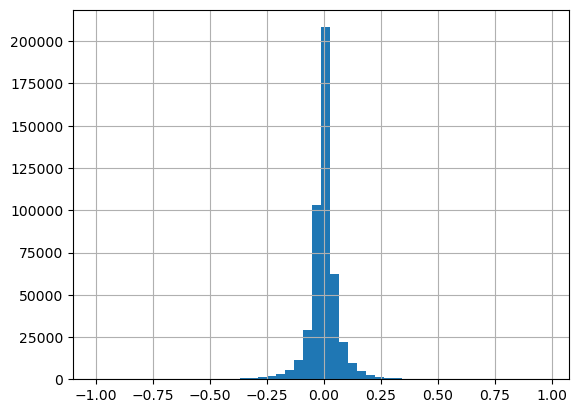

-1.0 -0.0005410768761350124 0.9753397497841649


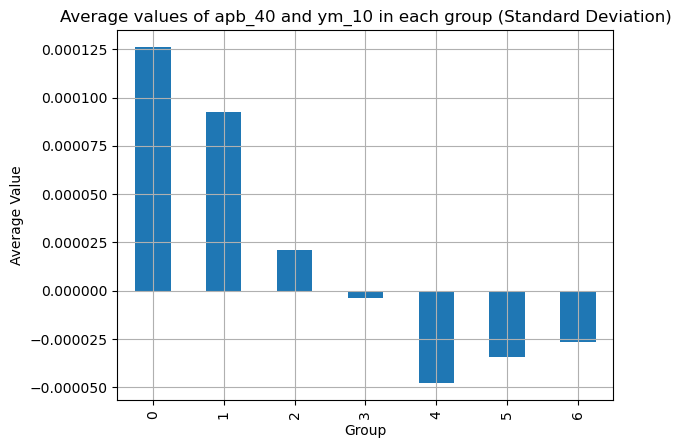

    group_std    apb_40     ym_10
0   -∞ to -3σ -0.296976  0.000126
1  -3σ to -2σ -0.155774  0.000092
2   -2σ to -σ -0.090593  0.000021
3    -σ to +σ  0.000409 -0.000004
4   +σ to +2σ  0.093848 -0.000048
5  +2σ to +3σ  0.160018 -0.000034
6   +3σ to +∞  0.260471 -0.000027


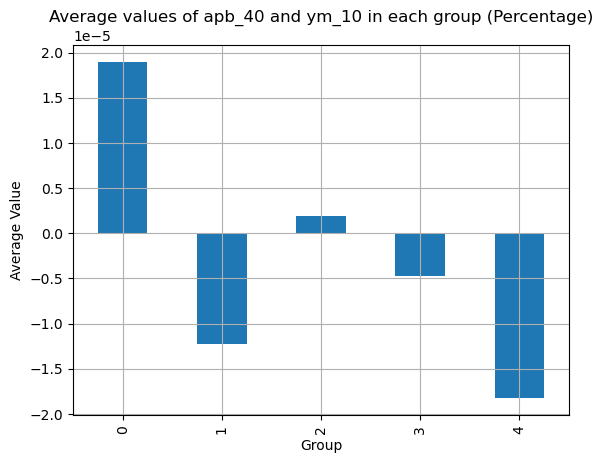

  group_percent    apb_40     ym_10
0         0-20% -0.084265  0.000019
1        20-40% -0.018521 -0.000012
2        40-60%  0.000088  0.000002
3        60-80%  0.019323 -0.000005
4       80-100%  0.080849 -0.000018


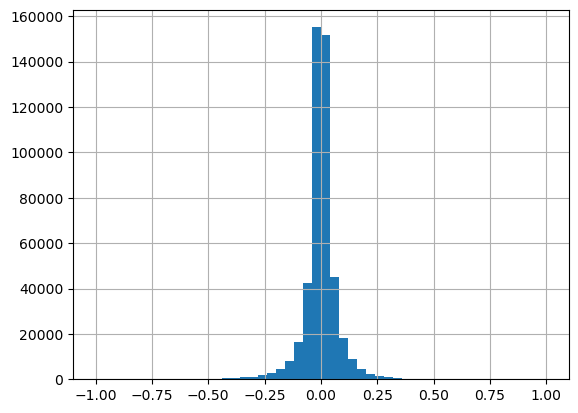

-1.0 -0.0009898968271137786 1.0


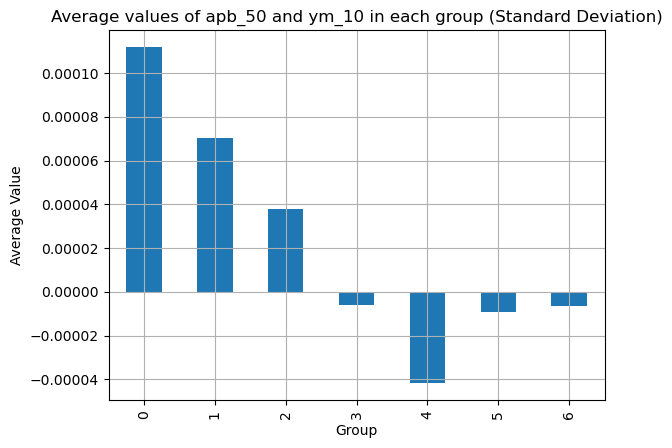

    group_std    apb_50     ym_10
0   -∞ to -3σ -0.330865  0.000112
1  -3σ to -2σ -0.177481  0.000070
2   -2σ to -σ -0.100889  0.000038
3    -σ to +σ  0.000824 -0.000006
4   +σ to +2σ  0.104896 -0.000042
5  +2σ to +3σ  0.178227 -0.000009
6   +3σ to +∞  0.286079 -0.000006


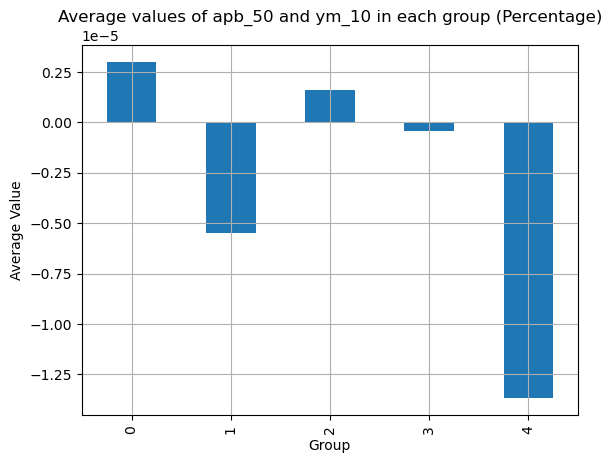

  group_percent    apb_50         ym_10
0         0-20% -0.094841  2.993166e-06
1        20-40% -0.020818 -5.471220e-06
2        40-60%  0.000377  1.605575e-06
3        60-80%  0.021895 -4.155235e-07
4       80-100%  0.088586 -1.368027e-05


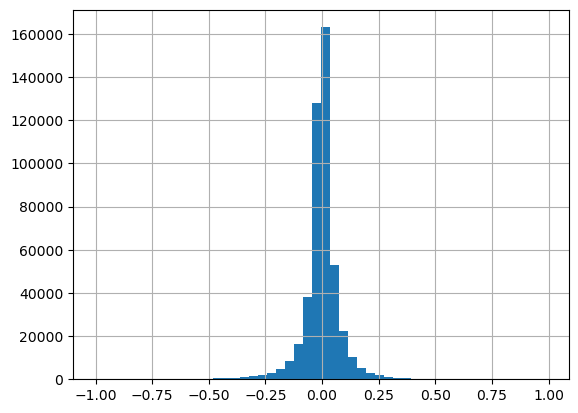

-1.0 -0.001473219594415568 0.990701144631501


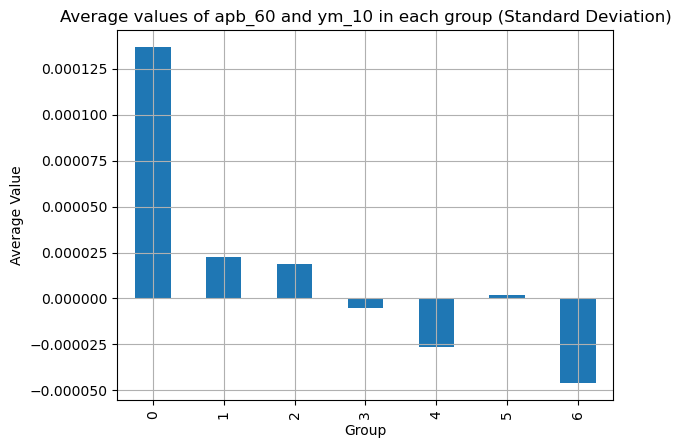

    group_std    apb_60     ym_10
0   -∞ to -3σ -0.361838  0.000137
1  -3σ to -2σ -0.193391  0.000023
2   -2σ to -σ -0.109765  0.000019
3    -σ to +σ  0.001240 -0.000005
4   +σ to +2σ  0.114094 -0.000026
5  +2σ to +3σ  0.191354  0.000002
6   +3σ to +∞  0.311918 -0.000046


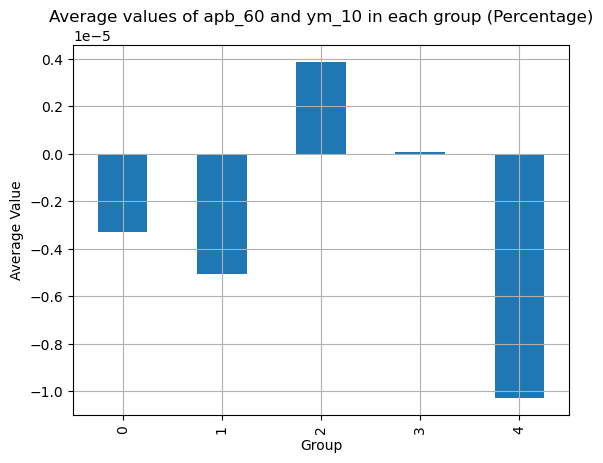

  group_percent    apb_60         ym_10
0         0-20% -0.104740 -3.276214e-06
1        20-40% -0.022743 -5.052777e-06
2        40-60%  0.000613  3.869495e-06
3        60-80%  0.024301  1.003032e-07
4       80-100%  0.095081 -1.027747e-05


In [21]:
for back_ticks in [10, 20, 30, 40, 50, 60]:
    assess_apb_wrt_return(data, back_ticks, 'ym_10')

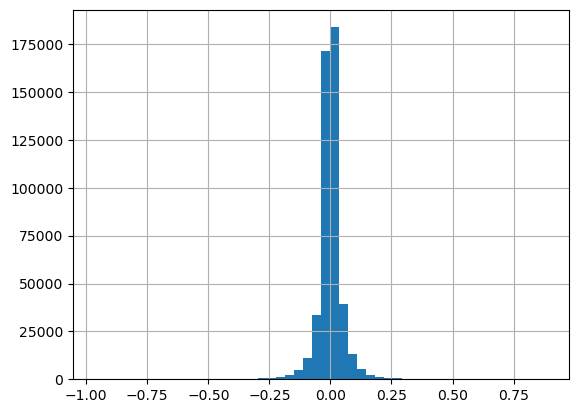

-0.9619318849965881 0.00010131855367300731 0.8846344351443753


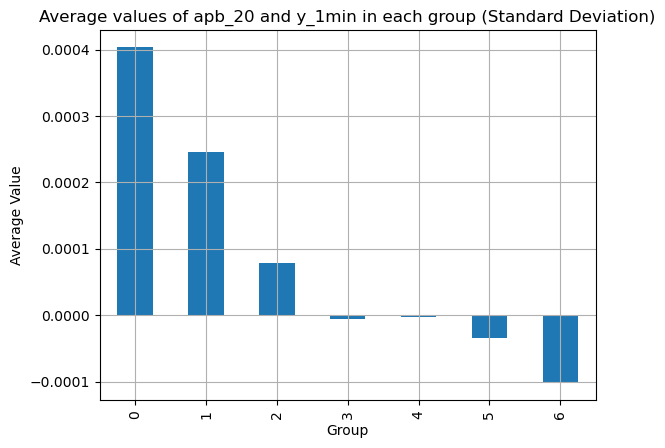

    group_std    apb_20    y_1min
0   -∞ to -3σ -0.209281  0.000404
1  -3σ to -2σ -0.114832  0.000245
2   -2σ to -σ -0.066754  0.000078
3    -σ to +σ -0.000171 -0.000006
4   +σ to +2σ  0.068812 -0.000003
5  +2σ to +3σ  0.117311 -0.000035
6   +3σ to +∞  0.205303 -0.000102


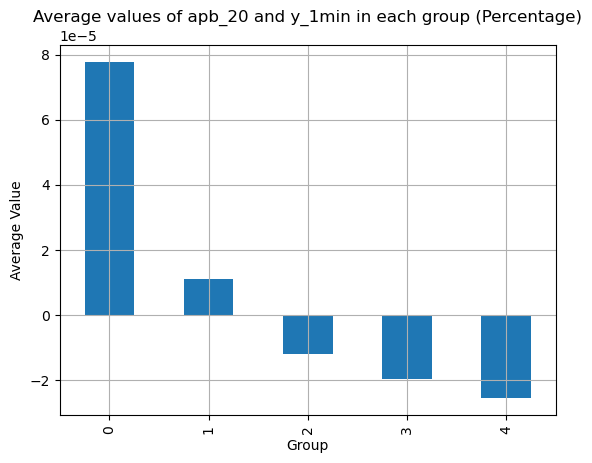

  group_percent    apb_20    y_1min
0         0-20% -0.060318  0.000078
1        20-40% -0.013805  0.000011
2        40-60% -0.000400 -0.000012
3        60-80%  0.013556 -0.000020
4       80-100%  0.061060 -0.000026


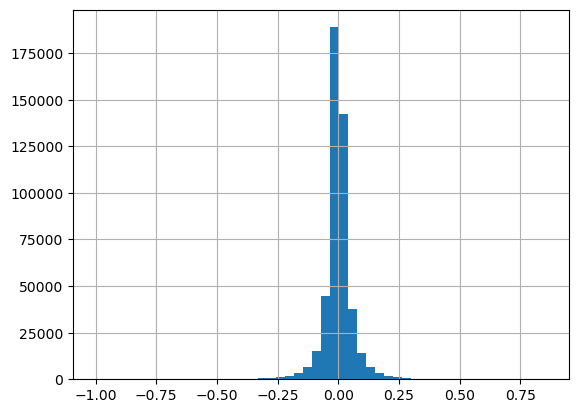

-1.0 -0.00014580826002696343 0.8581316035750737


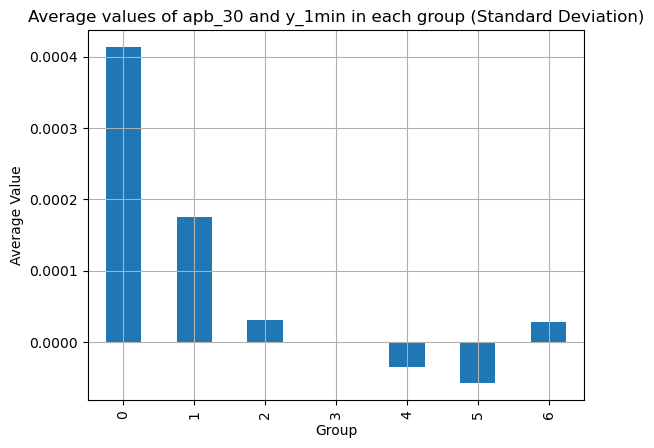

    group_std    apb_30        y_1min
0   -∞ to -3σ -0.254177  4.133945e-04
1  -3σ to -2σ -0.136702  1.753318e-04
2   -2σ to -σ -0.078929  3.098925e-05
3    -σ to +σ  0.000061  3.460528e-07
4   +σ to +2σ  0.081394 -3.416174e-05
5  +2σ to +3σ  0.139392 -5.732141e-05
6   +3σ to +∞  0.231666  2.801899e-05


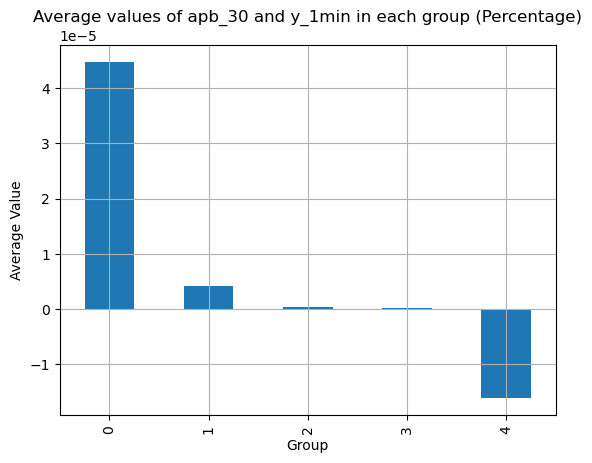

  group_percent    apb_30        y_1min
0         0-20% -0.072477  4.470065e-05
1        20-40% -0.016198  4.129015e-06
2        40-60% -0.000121  3.028911e-07
3        60-80%  0.016467  2.287005e-07
4       80-100%  0.071427 -1.609729e-05


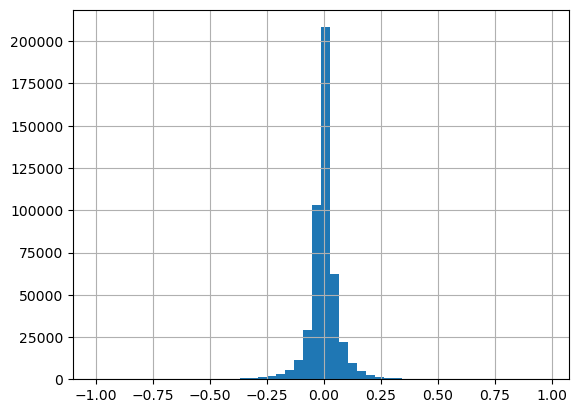

-1.0 -0.0005410768761350124 0.9753397497841649


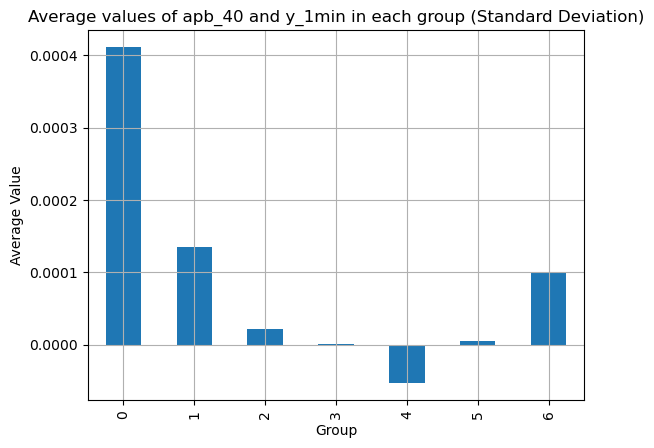

    group_std    apb_40    y_1min
0   -∞ to -3σ -0.296976  0.000411
1  -3σ to -2σ -0.155774  0.000134
2   -2σ to -σ -0.090593  0.000022
3    -σ to +σ  0.000409  0.000002
4   +σ to +2σ  0.093848 -0.000053
5  +2σ to +3σ  0.160018  0.000006
6   +3σ to +∞  0.260471  0.000099


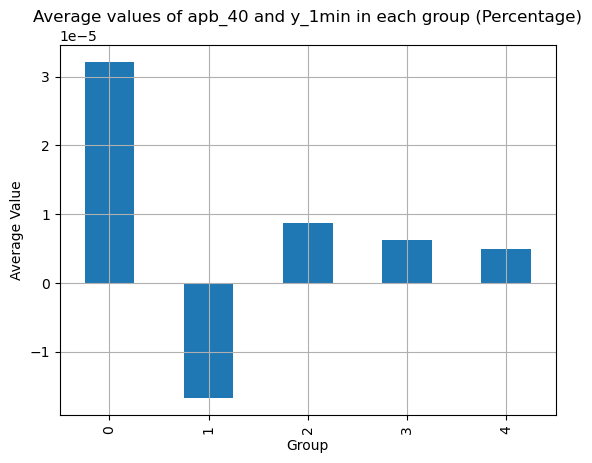

  group_percent    apb_40    y_1min
0         0-20% -0.084265  0.000032
1        20-40% -0.018521 -0.000017
2        40-60%  0.000088  0.000009
3        60-80%  0.019323  0.000006
4       80-100%  0.080849  0.000005


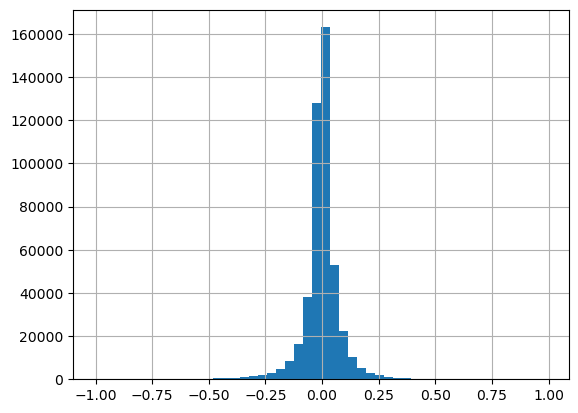

-1.0 -0.001473219594415568 0.990701144631501


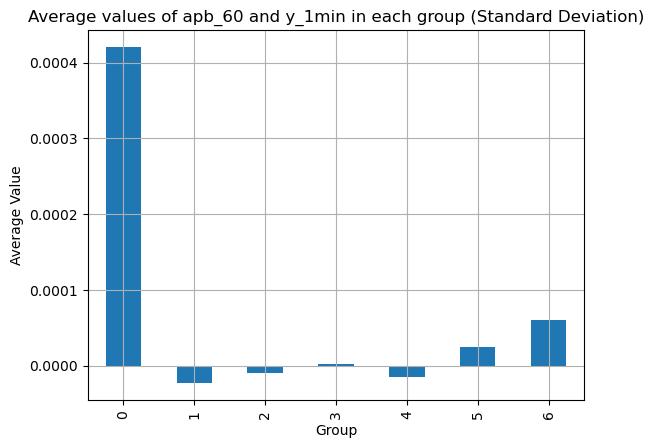

    group_std    apb_60    y_1min
0   -∞ to -3σ -0.361838  0.000420
1  -3σ to -2σ -0.193391 -0.000023
2   -2σ to -σ -0.109765 -0.000009
3    -σ to +σ  0.001240  0.000003
4   +σ to +2σ  0.114094 -0.000015
5  +2σ to +3σ  0.191354  0.000025
6   +3σ to +∞  0.311918  0.000060


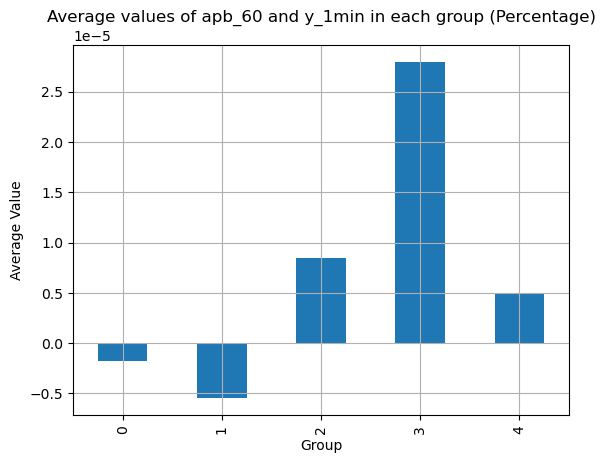

  group_percent    apb_60    y_1min
0         0-20% -0.104740 -0.000002
1        20-40% -0.022743 -0.000005
2        40-60%  0.000613  0.000008
3        60-80%  0.024301  0.000028
4       80-100%  0.095081  0.000005


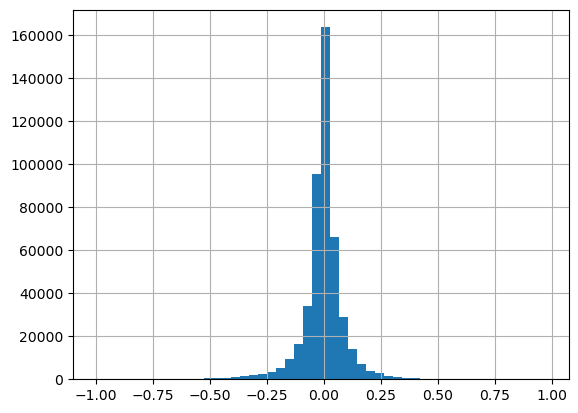

-1.0 -0.00245744062209518 0.9763695356909796


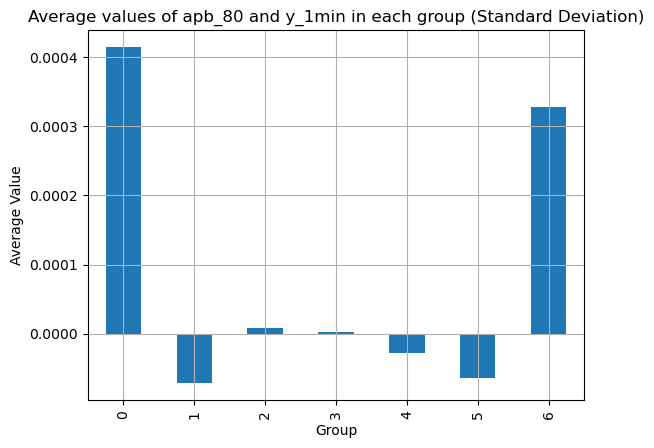

    group_std    apb_80    y_1min
0   -∞ to -3σ -0.412751  0.000414
1  -3σ to -2σ -0.224565 -0.000071
2   -2σ to -σ -0.127770  0.000009
3    -σ to +σ  0.001683  0.000003
4   +σ to +2σ  0.130726 -0.000027
5  +2σ to +3σ  0.216237 -0.000064
6   +3σ to +∞  0.350428  0.000327


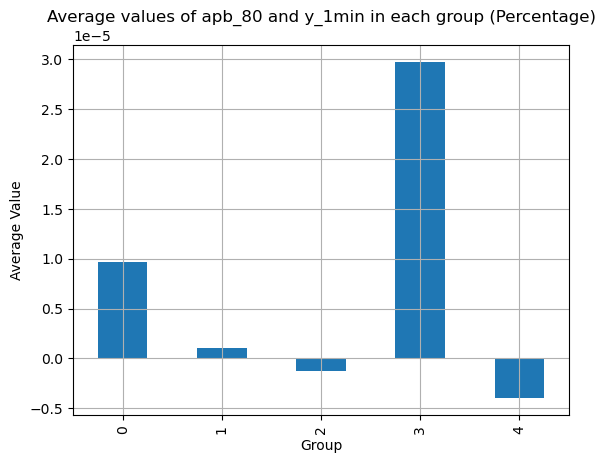

  group_percent    apb_80    y_1min
0         0-20% -0.121523  0.000010
1        20-40% -0.026186  0.000001
2        40-60%  0.000974 -0.000001
3        60-80%  0.028829  0.000030
4       80-100%  0.107353 -0.000004


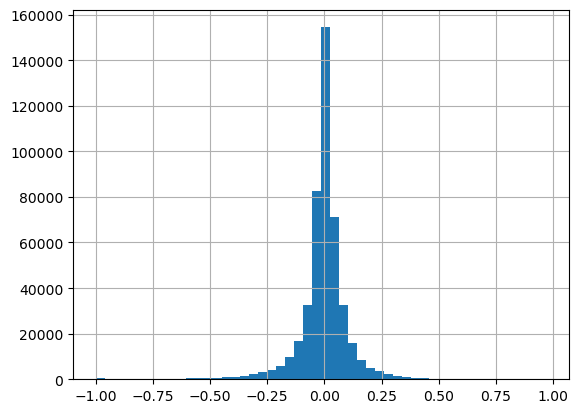

-1.0 -0.003443797226994865 0.9702446847824611


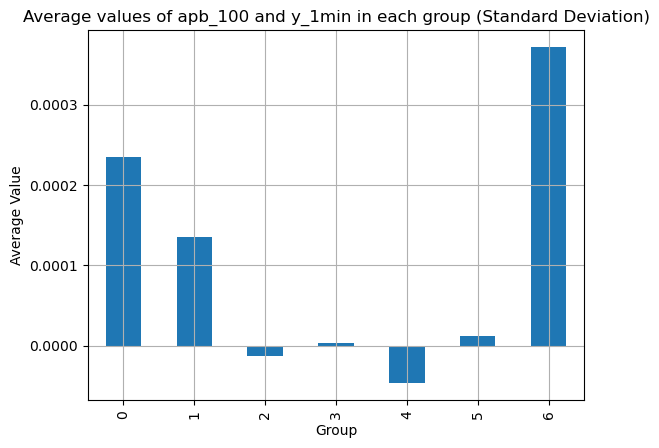

    group_std   apb_100    y_1min
0   -∞ to -3σ -0.455863  0.000234
1  -3σ to -2σ -0.250260  0.000135
2   -2σ to -σ -0.144619 -0.000013
3    -σ to +σ  0.002346  0.000003
4   +σ to +2σ  0.147327 -0.000046
5  +2σ to +3σ  0.234601  0.000013
6   +3σ to +∞  0.405245  0.000372


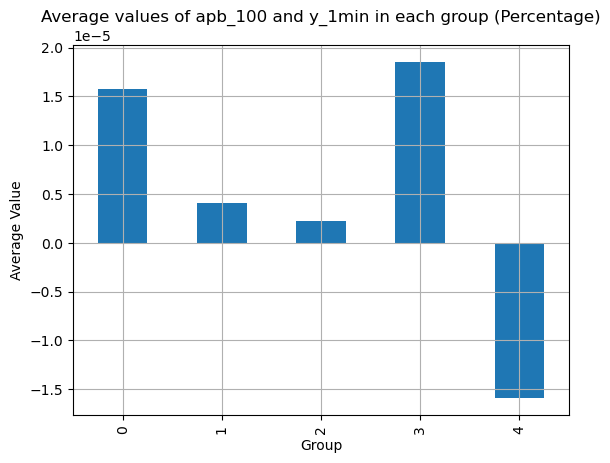

  group_percent   apb_100    y_1min
0         0-20% -0.136212  0.000016
1        20-40% -0.029826  0.000004
2        40-60%  0.001400  0.000002
3        60-80%  0.032148  0.000019
4       80-100%  0.117263 -0.000016


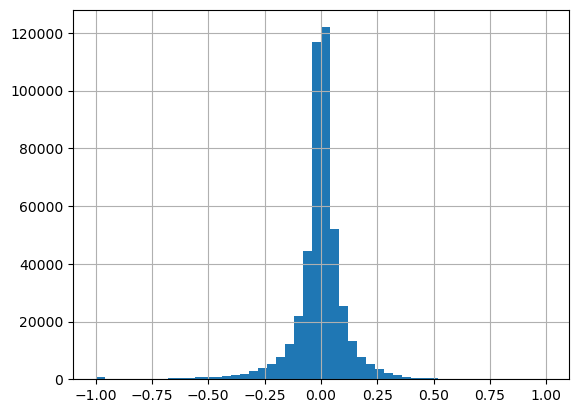

-1.0 -0.004415955894818257 1.0


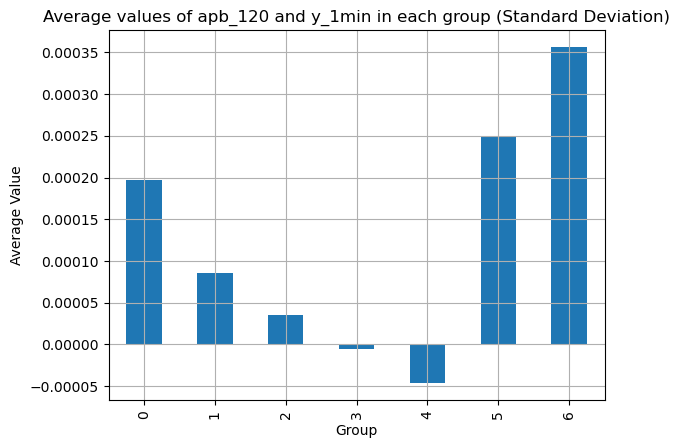

    group_std   apb_120    y_1min
0   -∞ to -3σ -0.491325  0.000197
1  -3σ to -2σ -0.267687  0.000086
2   -2σ to -σ -0.160510  0.000035
3    -σ to +σ  0.002863 -0.000006
4   +σ to +2σ  0.160992 -0.000046
5  +2σ to +3σ  0.255629  0.000250
6   +3σ to +∞  0.434496  0.000356


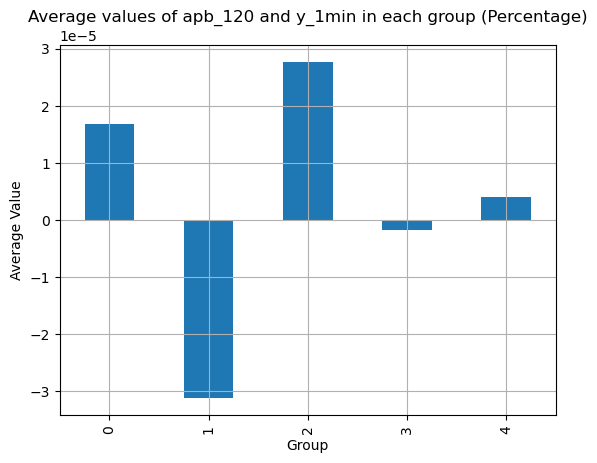

  group_percent   apb_120    y_1min
0         0-20% -0.150436  0.000017
1        20-40% -0.032912 -0.000031
2        40-60%  0.001896  0.000028
3        60-80%  0.034975 -0.000002
4       80-100%  0.125811  0.000004


In [22]:
for back_ticks in [20, 30, 40, 60, 80, 100, 120]:
    assess_apb_wrt_return(data, back_ticks, 'y_1min')

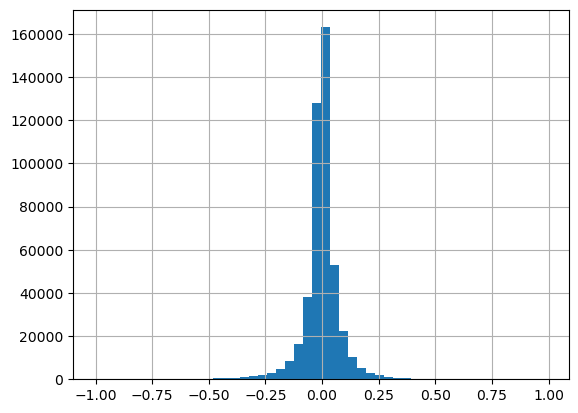

-1.0 -0.001473219594415568 0.990701144631501


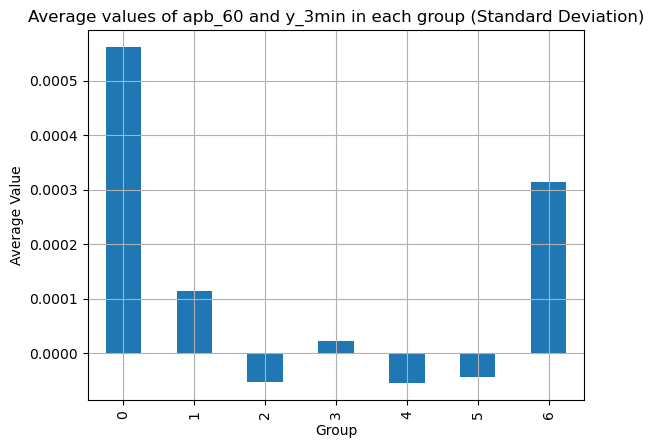

    group_std    apb_60    y_3min
0   -∞ to -3σ -0.361838  0.000561
1  -3σ to -2σ -0.193391  0.000114
2   -2σ to -σ -0.109765 -0.000053
3    -σ to +σ  0.001240  0.000023
4   +σ to +2σ  0.114094 -0.000054
5  +2σ to +3σ  0.191354 -0.000042
6   +3σ to +∞  0.311918  0.000313


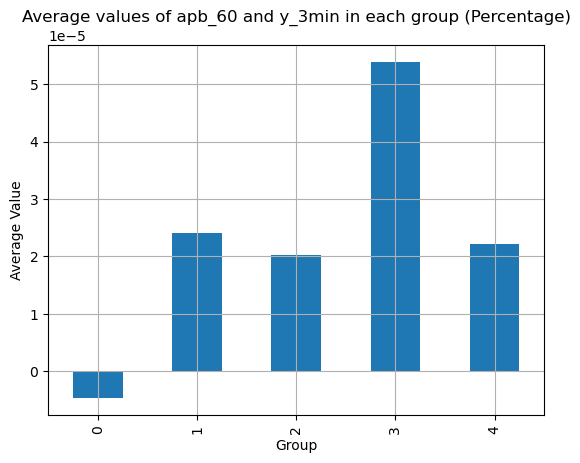

  group_percent    apb_60    y_3min
0         0-20% -0.104740 -0.000005
1        20-40% -0.022743  0.000024
2        40-60%  0.000613  0.000020
3        60-80%  0.024301  0.000054
4       80-100%  0.095081  0.000022


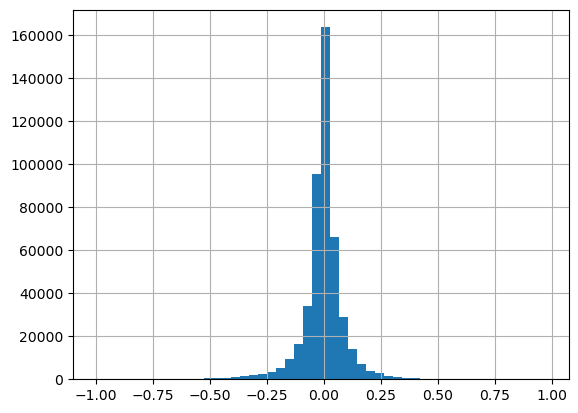

-1.0 -0.00245744062209518 0.9763695356909796


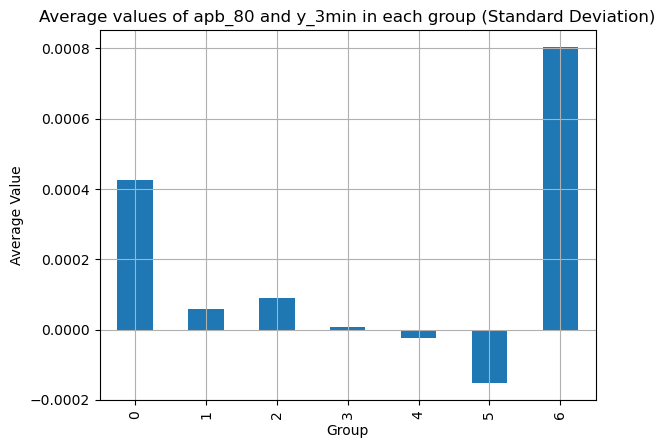

    group_std    apb_80    y_3min
0   -∞ to -3σ -0.412751  0.000426
1  -3σ to -2σ -0.224565  0.000058
2   -2σ to -σ -0.127770  0.000088
3    -σ to +σ  0.001683  0.000008
4   +σ to +2σ  0.130726 -0.000025
5  +2σ to +3σ  0.216237 -0.000152
6   +3σ to +∞  0.350428  0.000804


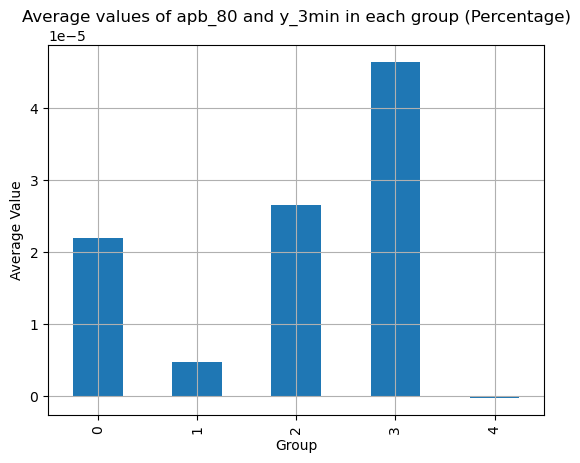

  group_percent    apb_80        y_3min
0         0-20% -0.121523  2.197224e-05
1        20-40% -0.026186  4.710264e-06
2        40-60%  0.000974  2.650848e-05
3        60-80%  0.028829  4.638757e-05
4       80-100%  0.107353 -2.272774e-07


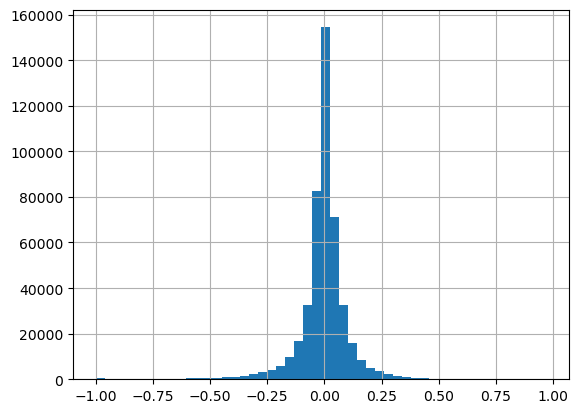

-1.0 -0.003443797226994865 0.9702446847824611


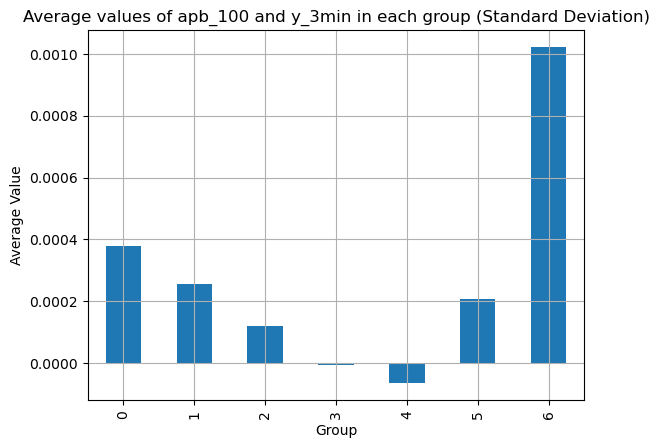

    group_std   apb_100    y_3min
0   -∞ to -3σ -0.455863  0.000380
1  -3σ to -2σ -0.250260  0.000257
2   -2σ to -σ -0.144619  0.000120
3    -σ to +σ  0.002346 -0.000007
4   +σ to +2σ  0.147327 -0.000065
5  +2σ to +3σ  0.234601  0.000206
6   +3σ to +∞  0.405245  0.001023


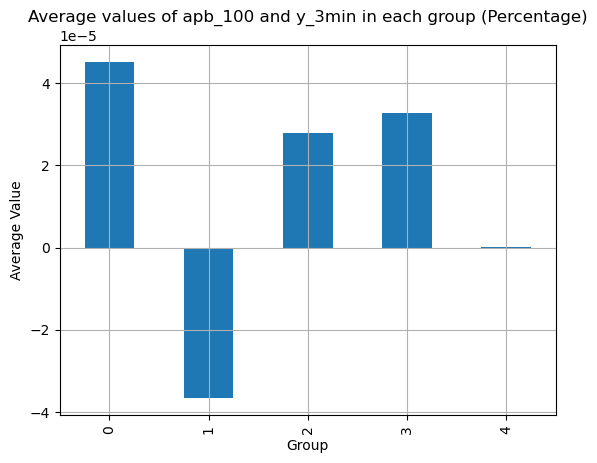

  group_percent   apb_100        y_3min
0         0-20% -0.136212  4.518833e-05
1        20-40% -0.029826 -3.665576e-05
2        40-60%  0.001400  2.790240e-05
3        60-80%  0.032148  3.285934e-05
4       80-100%  0.117263  1.727996e-07


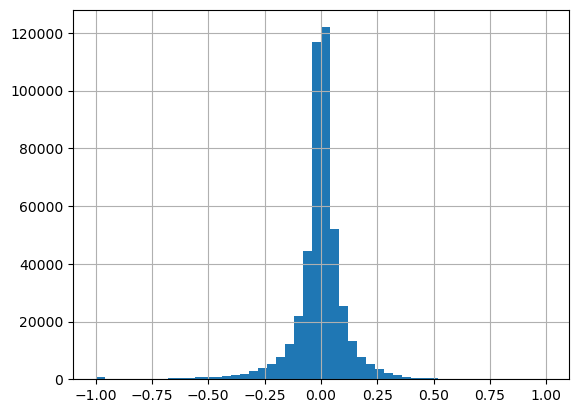

-1.0 -0.004415955894818257 1.0


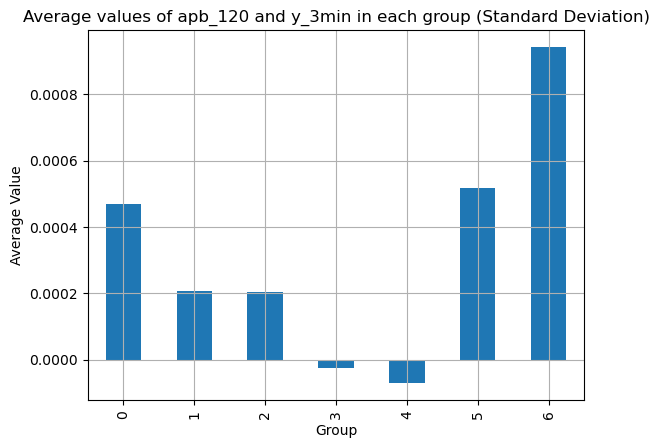

    group_std   apb_120    y_3min
0   -∞ to -3σ -0.491325  0.000471
1  -3σ to -2σ -0.267687  0.000208
2   -2σ to -σ -0.160510  0.000205
3    -σ to +σ  0.002863 -0.000026
4   +σ to +2σ  0.160992 -0.000070
5  +2σ to +3σ  0.255629  0.000517
6   +3σ to +∞  0.434496  0.000942


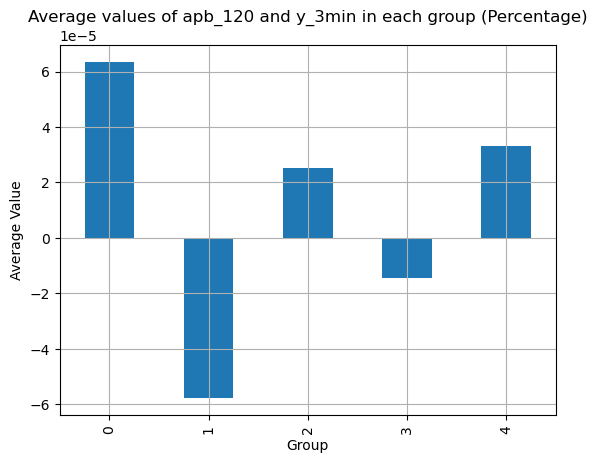

  group_percent   apb_120    y_3min
0         0-20% -0.150436  0.000063
1        20-40% -0.032912 -0.000058
2        40-60%  0.001896  0.000025
3        60-80%  0.034975 -0.000015
4       80-100%  0.125811  0.000033


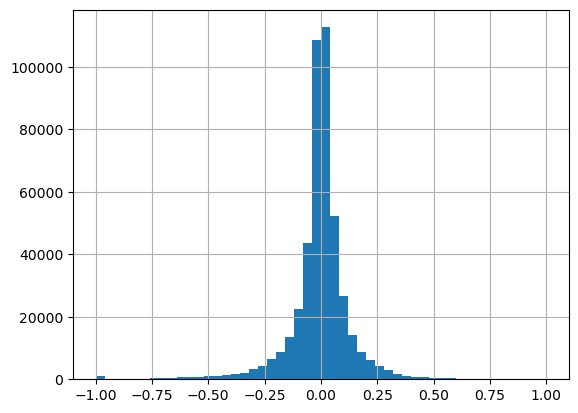

-1.0 -0.005900001150522424 1.0


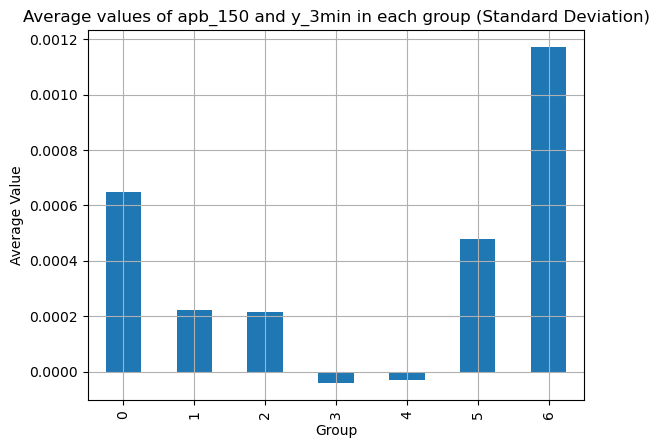

    group_std   apb_150    y_3min
0   -∞ to -3σ -0.535969  0.000648
1  -3σ to -2σ -0.301795  0.000223
2   -2σ to -σ -0.180115  0.000214
3    -σ to +σ  0.003710 -0.000042
4   +σ to +2σ  0.178612 -0.000030
5  +2σ to +3σ  0.288858  0.000479
6   +3σ to +∞  0.496367  0.001173


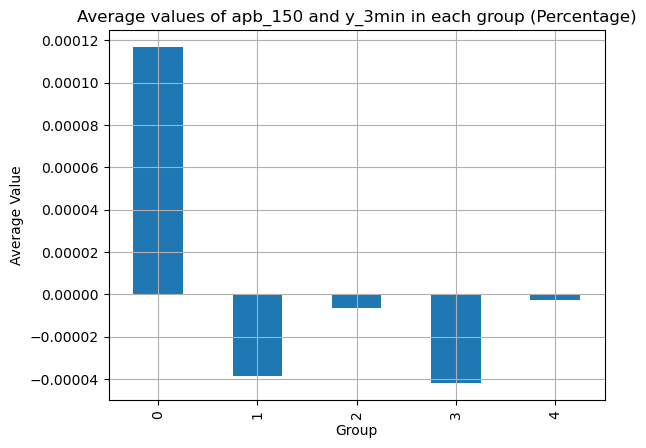

  group_percent   apb_150    y_3min
0         0-20% -0.169283  0.000117
1        20-40% -0.037440 -0.000038
2        40-60%  0.002392 -0.000006
3        60-80%  0.038598 -0.000042
4       80-100%  0.137908 -0.000003


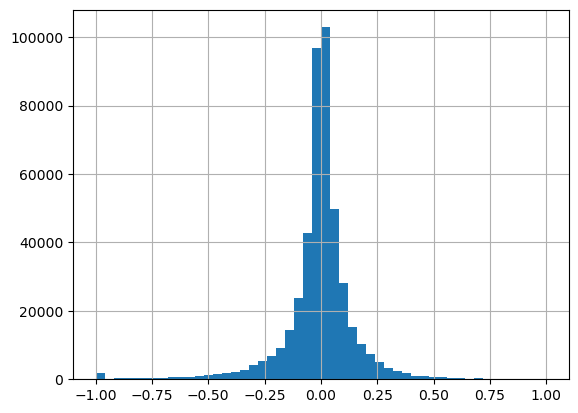

-1.0 -0.00835908816766424 1.0


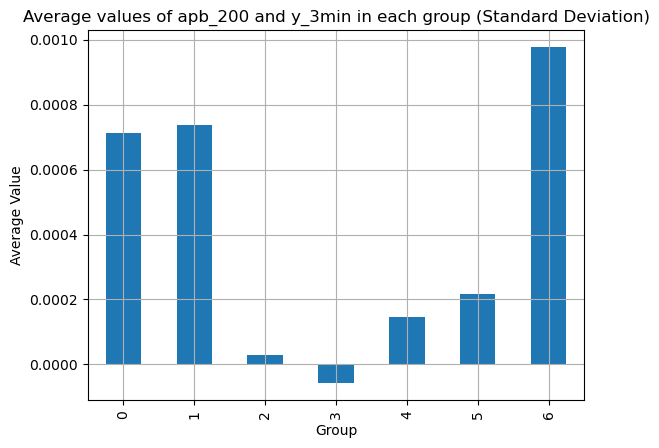

    group_std   apb_200    y_3min
0   -∞ to -3σ -0.611562  0.000713
1  -3σ to -2σ -0.359245  0.000737
2   -2σ to -σ -0.209366  0.000029
3    -σ to +σ  0.004681 -0.000058
4   +σ to +2σ  0.204853  0.000147
5  +2σ to +3σ  0.333205  0.000218
6   +3σ to +∞  0.581511  0.000978


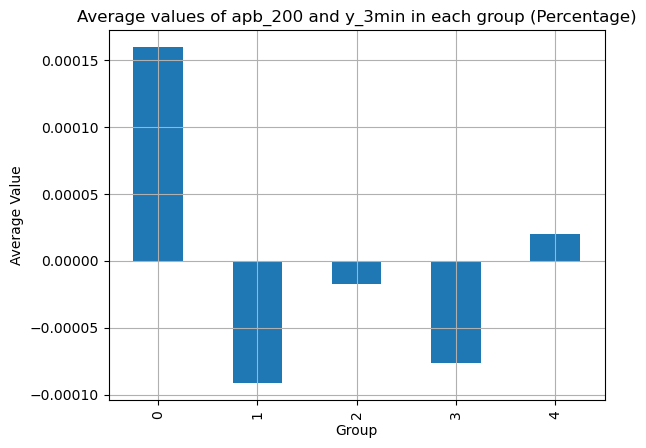

  group_percent   apb_200    y_3min
0         0-20% -0.192105  0.000160
1        20-40% -0.045068 -0.000091
2        40-60%  0.001983 -0.000018
3        60-80%  0.045596 -0.000077
4       80-100%  0.155294  0.000020


In [23]:
for back_ticks in [60, 80, 100, 120, 150, 200]:
    assess_apb_wrt_return(data, back_ticks, 'y_3min')

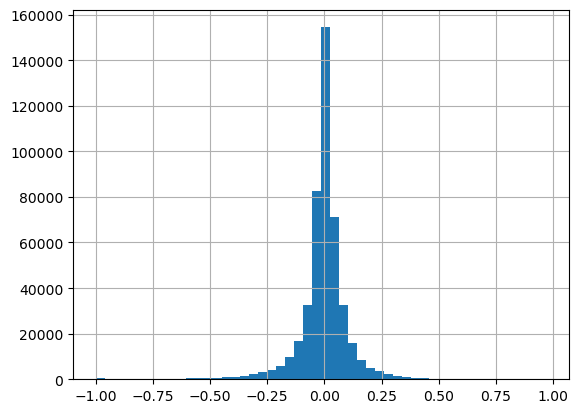

-1.0 -0.003443797226994865 0.9702446847824611


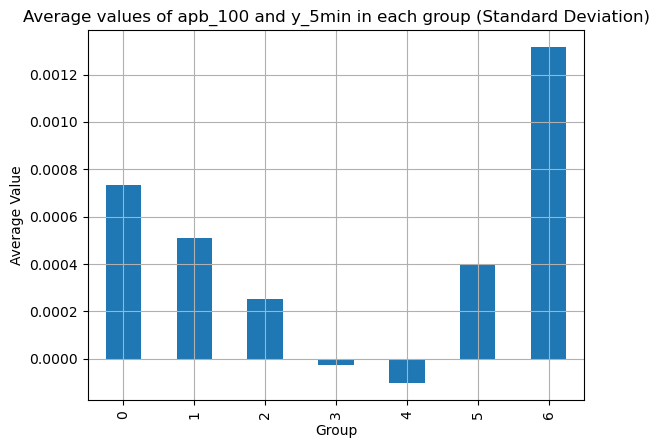

    group_std   apb_100    y_5min
0   -∞ to -3σ -0.455863  0.000732
1  -3σ to -2σ -0.250260  0.000509
2   -2σ to -σ -0.144619  0.000250
3    -σ to +σ  0.002346 -0.000026
4   +σ to +2σ  0.147327 -0.000103
5  +2σ to +3σ  0.234601  0.000400
6   +3σ to +∞  0.405245  0.001316


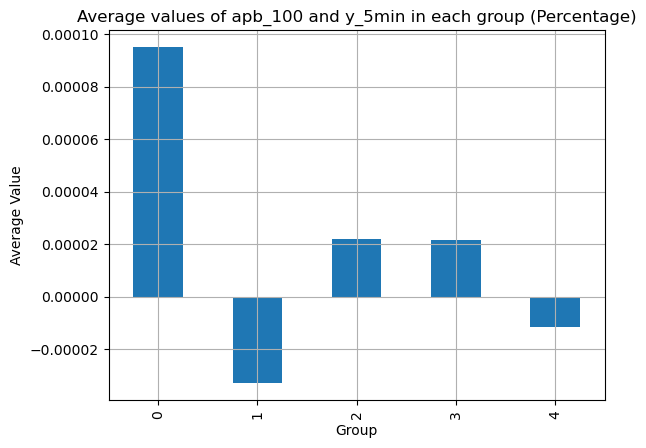

  group_percent   apb_100    y_5min
0         0-20% -0.136212  0.000095
1        20-40% -0.029826 -0.000033
2        40-60%  0.001400  0.000022
3        60-80%  0.032148  0.000022
4       80-100%  0.117263 -0.000011


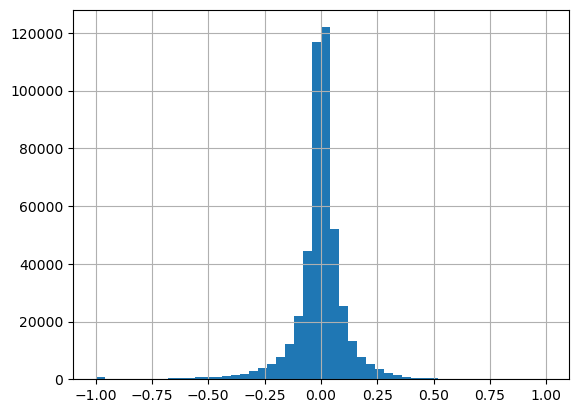

-1.0 -0.004415955894818257 1.0


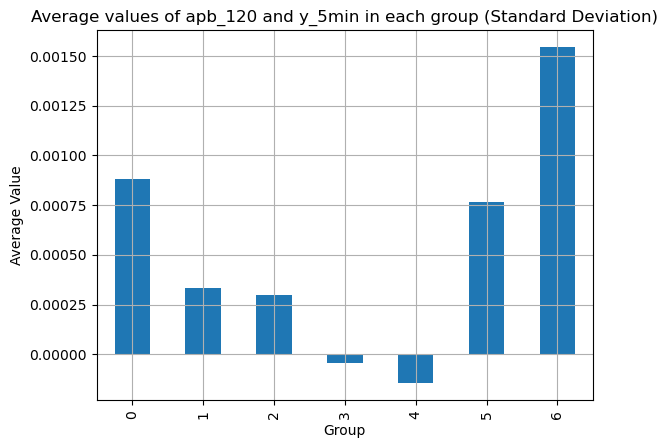

    group_std   apb_120    y_5min
0   -∞ to -3σ -0.491325  0.000881
1  -3σ to -2σ -0.267687  0.000336
2   -2σ to -σ -0.160510  0.000301
3    -σ to +σ  0.002863 -0.000043
4   +σ to +2σ  0.160992 -0.000144
5  +2σ to +3σ  0.255629  0.000768
6   +3σ to +∞  0.434496  0.001545


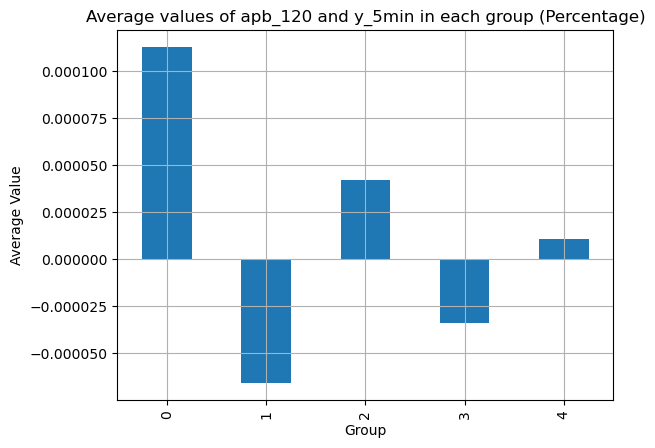

  group_percent   apb_120    y_5min
0         0-20% -0.150436  0.000113
1        20-40% -0.032912 -0.000066
2        40-60%  0.001896  0.000042
3        60-80%  0.034975 -0.000034
4       80-100%  0.125811  0.000011


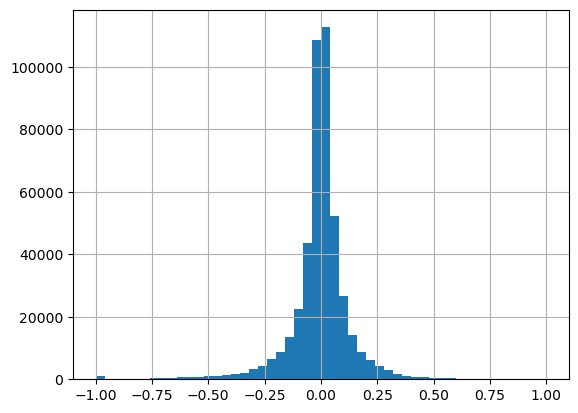

-1.0 -0.005900001150522424 1.0


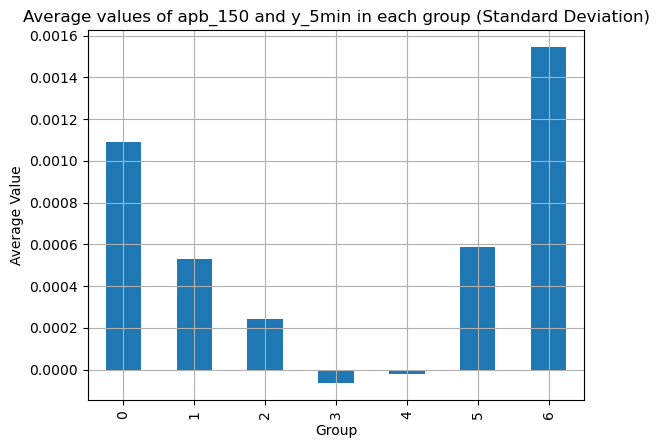

    group_std   apb_150    y_5min
0   -∞ to -3σ -0.535969  0.001093
1  -3σ to -2σ -0.301795  0.000530
2   -2σ to -σ -0.180115  0.000243
3    -σ to +σ  0.003710 -0.000065
4   +σ to +2σ  0.178612 -0.000021
5  +2σ to +3σ  0.288858  0.000588
6   +3σ to +∞  0.496367  0.001546


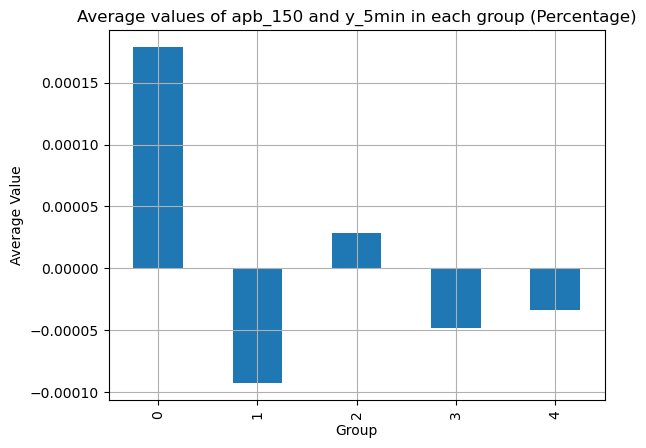

  group_percent   apb_150    y_5min
0         0-20% -0.169283  0.000179
1        20-40% -0.037440 -0.000093
2        40-60%  0.002392  0.000028
3        60-80%  0.038598 -0.000048
4       80-100%  0.137908 -0.000033


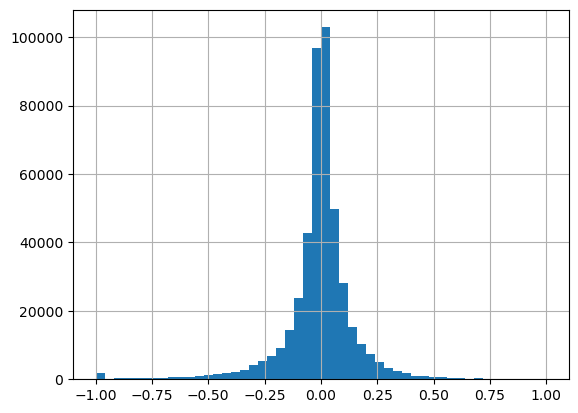

-1.0 -0.00835908816766424 1.0


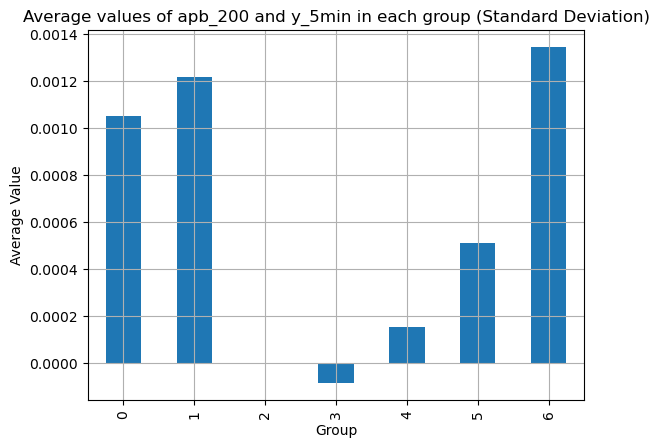

    group_std   apb_200    y_5min
0   -∞ to -3σ -0.611562  0.001050
1  -3σ to -2σ -0.359245  0.001218
2   -2σ to -σ -0.209366 -0.000006
3    -σ to +σ  0.004681 -0.000085
4   +σ to +2σ  0.204853  0.000153
5  +2σ to +3σ  0.333205  0.000511
6   +3σ to +∞  0.581511  0.001344


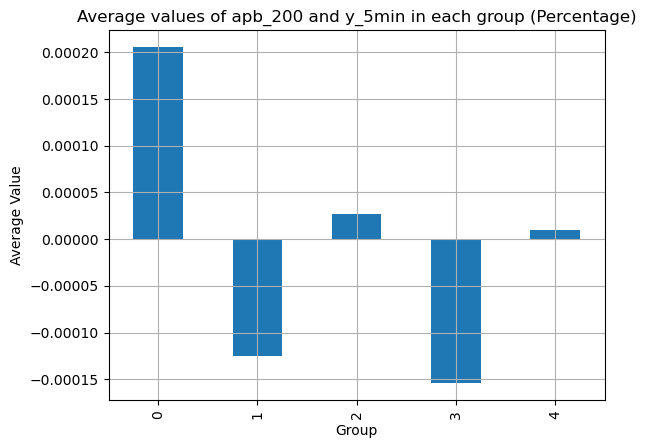

  group_percent   apb_200    y_5min
0         0-20% -0.192105  0.000206
1        20-40% -0.045068 -0.000126
2        40-60%  0.001983  0.000027
3        60-80%  0.045596 -0.000154
4       80-100%  0.155294  0.000010


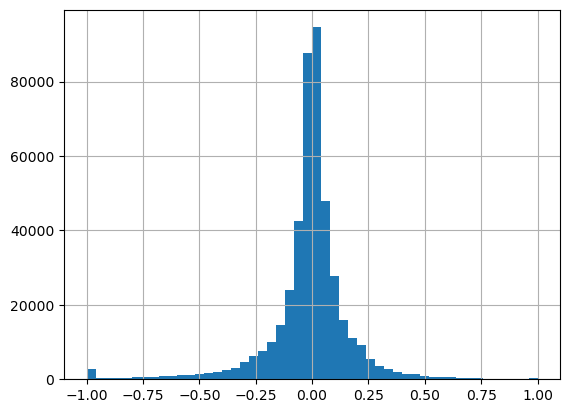

-1.0 -0.010633815327621818 1.0


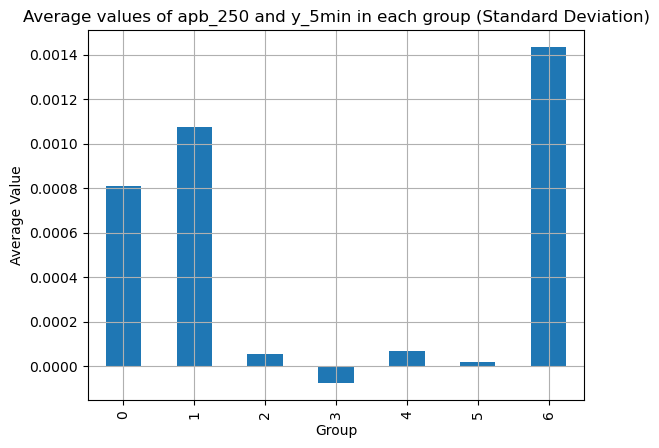

    group_std   apb_250    y_5min
0   -∞ to -3σ -0.658627  0.000808
1  -3σ to -2σ -0.405648  0.001076
2   -2σ to -σ -0.230407  0.000054
3    -σ to +σ  0.005041 -0.000076
4   +σ to +2σ  0.228717  0.000067
5  +2σ to +3σ  0.382246  0.000018
6   +3σ to +∞  0.625479  0.001434


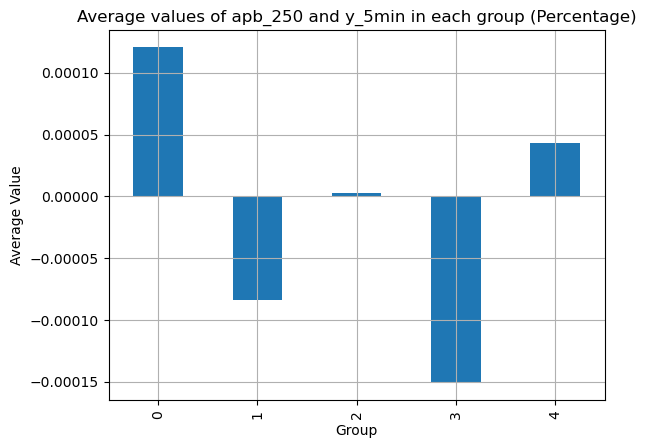

  group_percent   apb_250    y_5min
0         0-20% -0.211307  0.000121
1        20-40% -0.052303 -0.000084
2        40-60%  0.000817  0.000003
3        60-80%  0.050955 -0.000151
4       80-100%  0.172544  0.000043


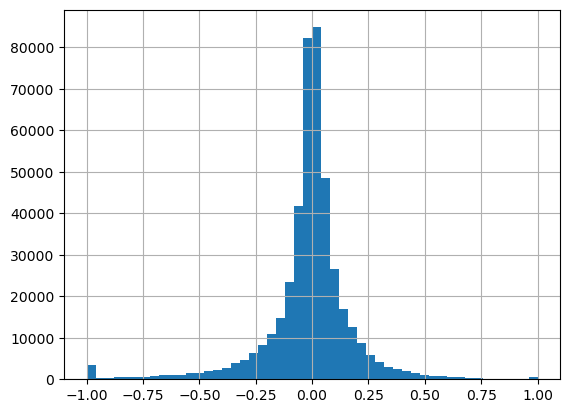

-1.0 -0.012632132679902446 1.0


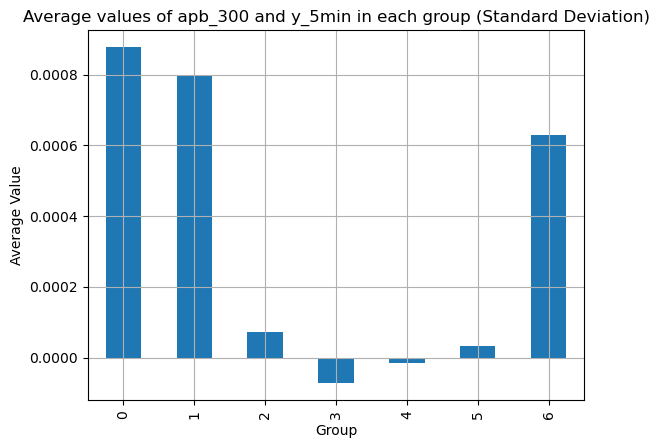

    group_std   apb_300    y_5min
0   -∞ to -3σ -0.675800  0.000878
1  -3σ to -2σ -0.443899  0.000796
2   -2σ to -σ -0.252577  0.000072
3    -σ to +σ  0.005415 -0.000072
4   +σ to +2σ  0.258028 -0.000015
5  +2σ to +3σ  0.428285  0.000032
6   +3σ to +∞  0.645125  0.000630


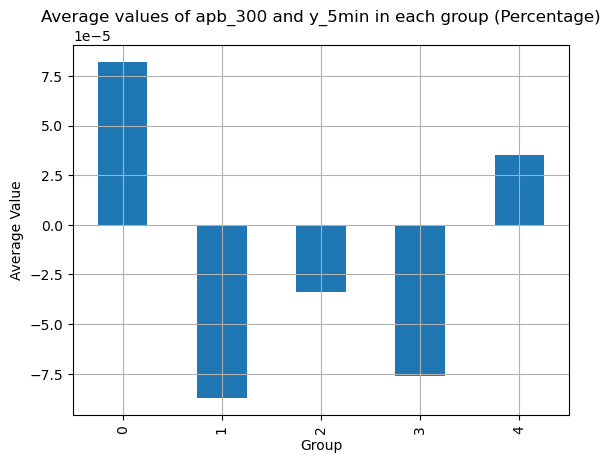

  group_percent   apb_300    y_5min
0         0-20% -0.228008  0.000082
1        20-40% -0.059922 -0.000087
2        40-60%  0.000275 -0.000034
3        60-80%  0.056083 -0.000076
4       80-100%  0.186682  0.000035


In [24]:
for back_ticks in [100, 120, 150, 200, 250, 300]:
    assess_apb_wrt_return(data, back_ticks, 'y_5min')

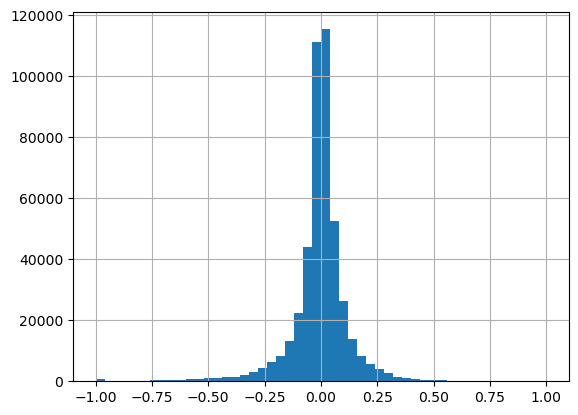

-1.0 -0.005394916619003364 1.0


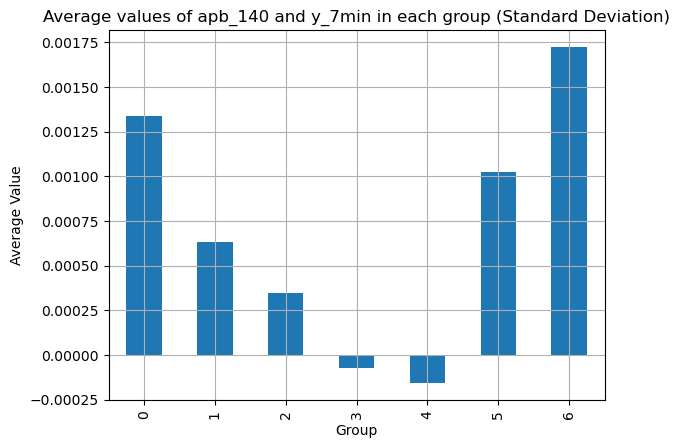

    group_std   apb_140    y_7min
0   -∞ to -3σ -0.521011  0.001340
1  -3σ to -2σ -0.291827  0.000631
2   -2σ to -σ -0.174480  0.000345
3    -σ to +σ  0.003418 -0.000075
4   +σ to +2σ  0.172910 -0.000157
5  +2σ to +3σ  0.283657  0.001025
6   +3σ to +∞  0.469760  0.001724


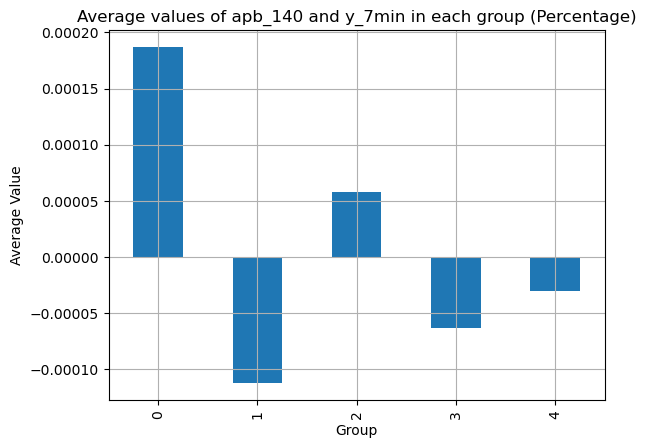

  group_percent   apb_140    y_7min
0         0-20% -0.163439  0.000187
1        20-40% -0.035949 -0.000112
2        40-60%  0.002359  0.000058
3        60-80%  0.037224 -0.000063
4       80-100%  0.133675 -0.000031


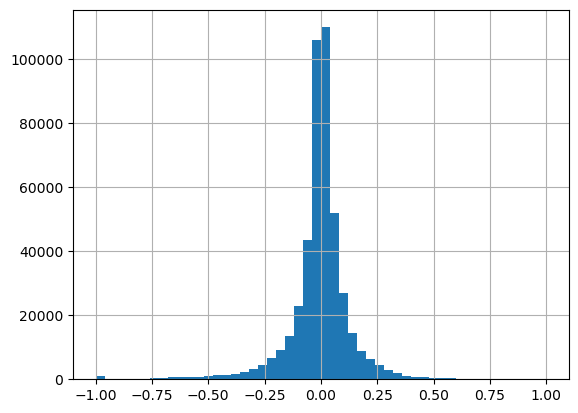

-1.0 -0.006407685416233279 1.0


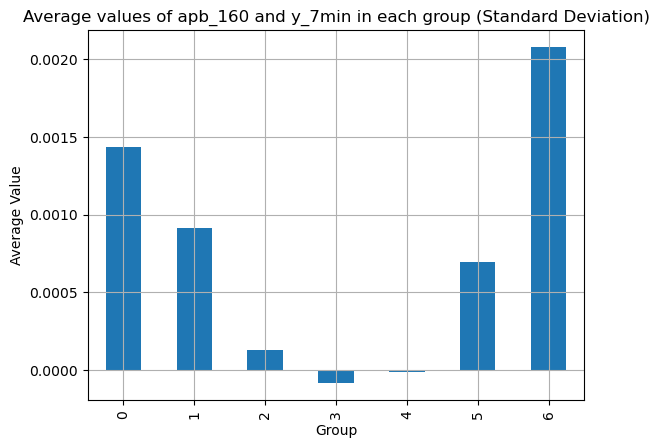

    group_std   apb_160    y_7min
0   -∞ to -3σ -0.552594  0.001434
1  -3σ to -2σ -0.310618  0.000913
2   -2σ to -σ -0.186474  0.000130
3    -σ to +σ  0.003843 -0.000083
4   +σ to +2σ  0.183536 -0.000013
5  +2σ to +3σ  0.298527  0.000699
6   +3σ to +∞  0.518412  0.002079


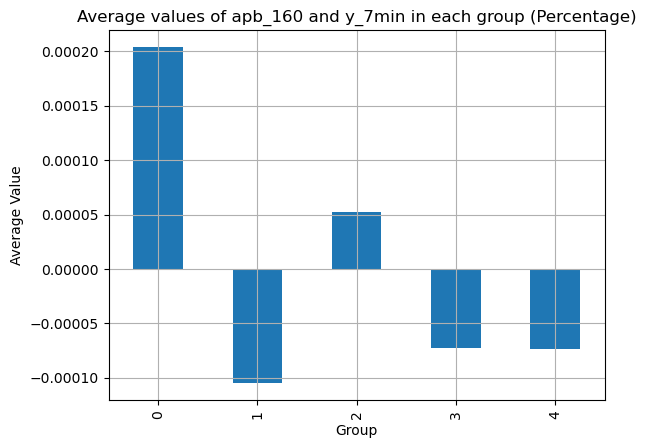

  group_percent   apb_160    y_7min
0         0-20% -0.174623  0.000204
1        20-40% -0.039151 -0.000105
2        40-60%  0.002208  0.000052
3        60-80%  0.039901 -0.000072
4       80-100%  0.141696 -0.000073


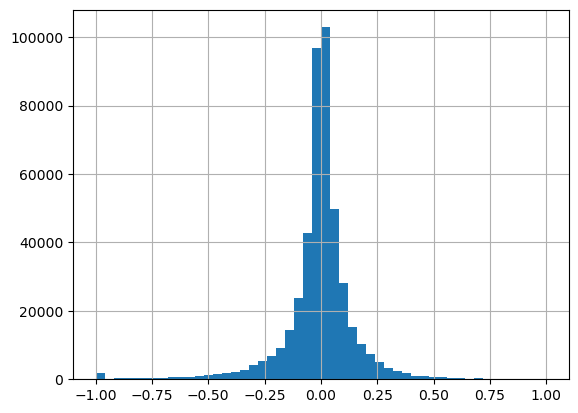

-1.0 -0.00835908816766424 1.0


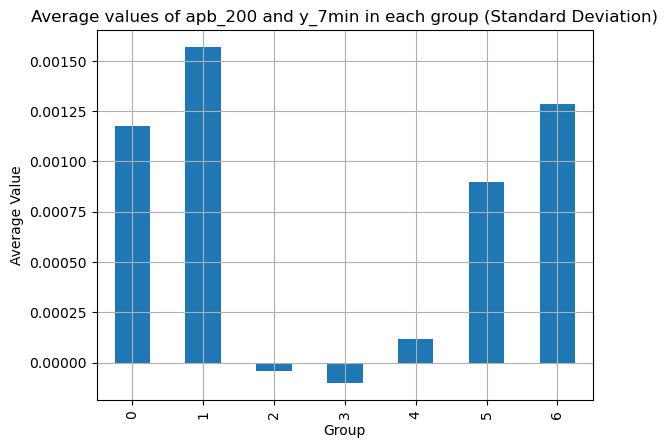

    group_std   apb_200    y_7min
0   -∞ to -3σ -0.611562  0.001178
1  -3σ to -2σ -0.359245  0.001569
2   -2σ to -σ -0.209366 -0.000043
3    -σ to +σ  0.004681 -0.000102
4   +σ to +2σ  0.204853  0.000117
5  +2σ to +3σ  0.333205  0.000899
6   +3σ to +∞  0.581511  0.001286


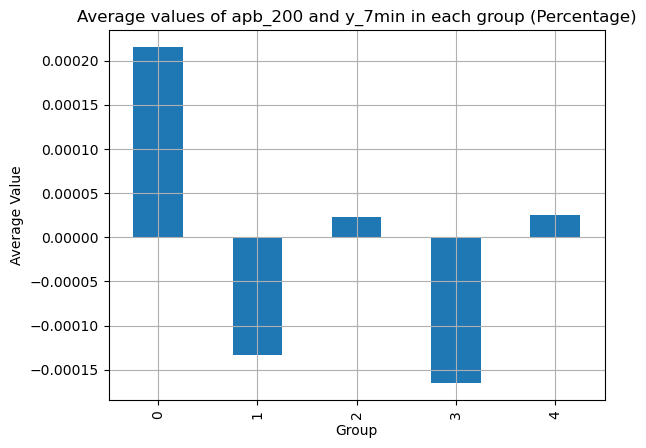

  group_percent   apb_200    y_7min
0         0-20% -0.192105  0.000215
1        20-40% -0.045068 -0.000133
2        40-60%  0.001983  0.000023
3        60-80%  0.045596 -0.000165
4       80-100%  0.155294  0.000025


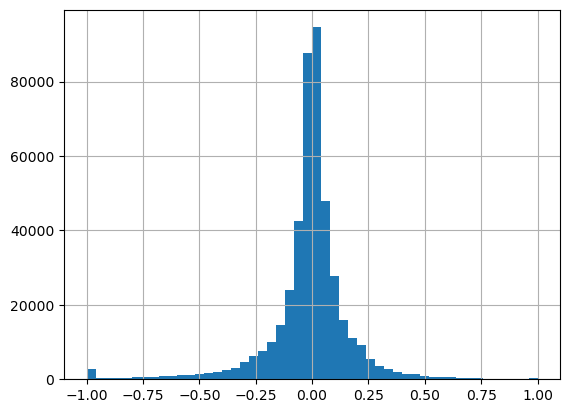

-1.0 -0.010633815327621818 1.0


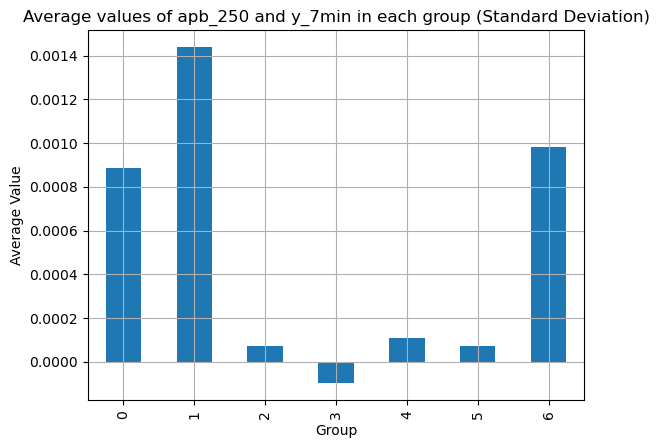

    group_std   apb_250    y_7min
0   -∞ to -3σ -0.658627  0.000888
1  -3σ to -2σ -0.405648  0.001439
2   -2σ to -σ -0.230407  0.000072
3    -σ to +σ  0.005041 -0.000098
4   +σ to +2σ  0.228717  0.000110
5  +2σ to +3σ  0.382246  0.000074
6   +3σ to +∞  0.625479  0.000984


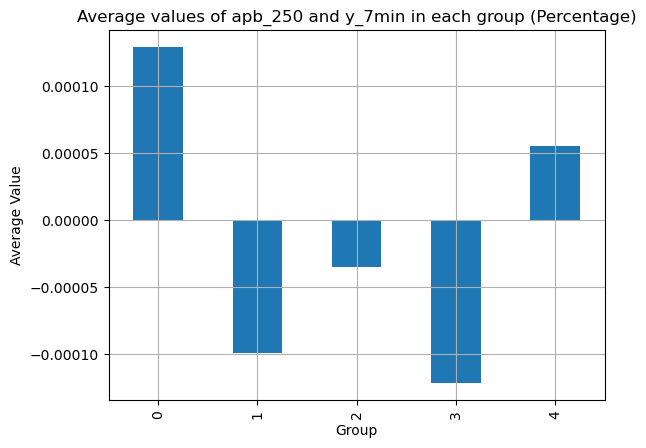

  group_percent   apb_250    y_7min
0         0-20% -0.211307  0.000129
1        20-40% -0.052303 -0.000099
2        40-60%  0.000817 -0.000035
3        60-80%  0.050955 -0.000122
4       80-100%  0.172544  0.000056


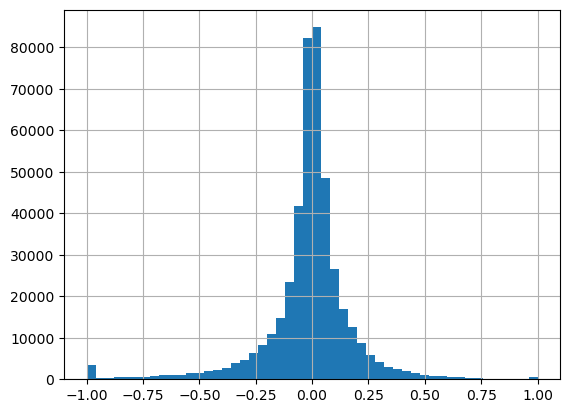

-1.0 -0.012632132679902446 1.0


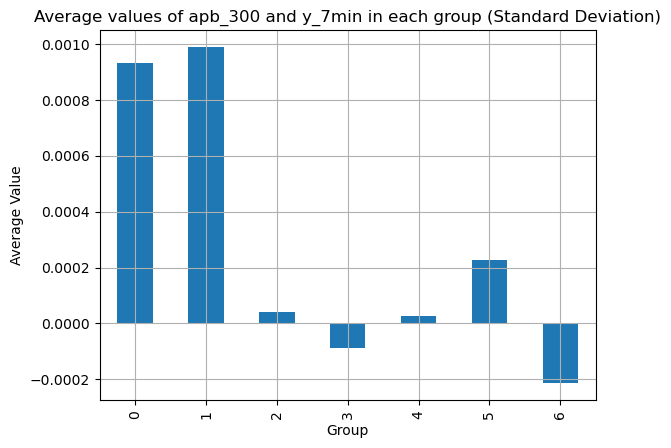

    group_std   apb_300    y_7min
0   -∞ to -3σ -0.675800  0.000934
1  -3σ to -2σ -0.443899  0.000990
2   -2σ to -σ -0.252577  0.000041
3    -σ to +σ  0.005415 -0.000089
4   +σ to +2σ  0.258028  0.000025
5  +2σ to +3σ  0.428285  0.000226
6   +3σ to +∞  0.645125 -0.000214


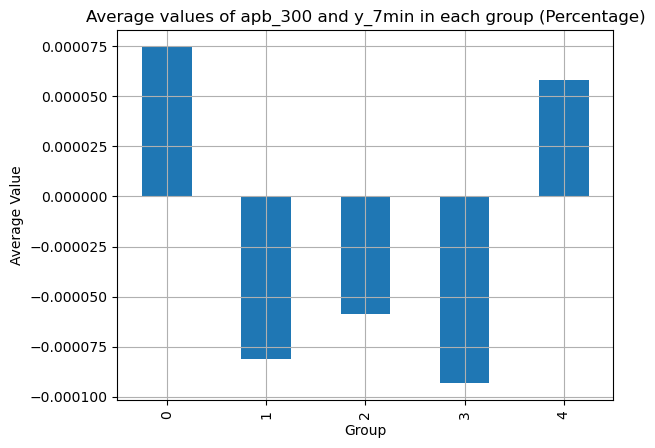

  group_percent   apb_300    y_7min
0         0-20% -0.228008  0.000075
1        20-40% -0.059922 -0.000081
2        40-60%  0.000275 -0.000059
3        60-80%  0.056083 -0.000093
4       80-100%  0.186682  0.000058


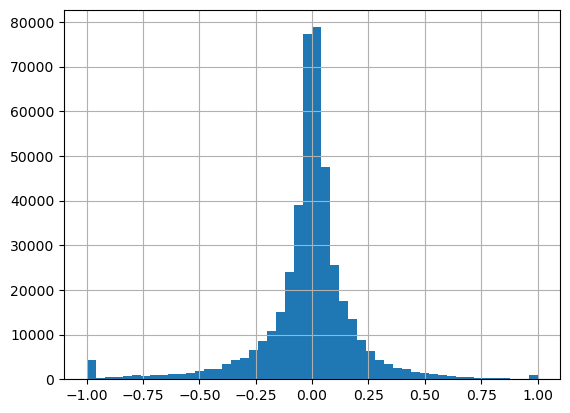

-1.0 -0.014477709131384357 1.0


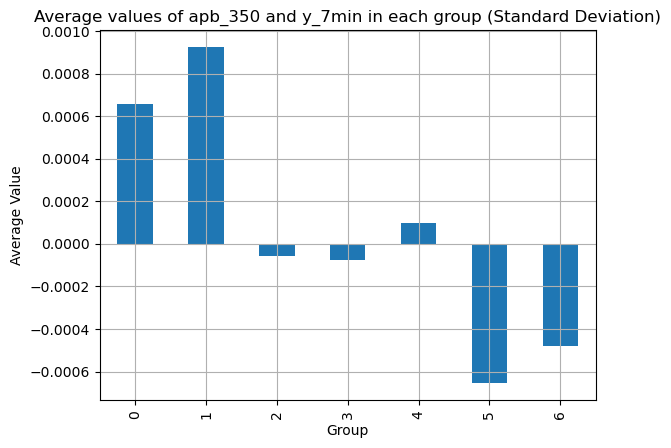

    group_std   apb_350    y_7min
0   -∞ to -3σ -0.698091  0.000659
1  -3σ to -2σ -0.488138  0.000925
2   -2σ to -σ -0.267127 -0.000057
3    -σ to +σ  0.006355 -0.000076
4   +σ to +2σ  0.283730  0.000096
5  +2σ to +3σ  0.463676 -0.000654
6   +3σ to +∞  0.656925 -0.000479


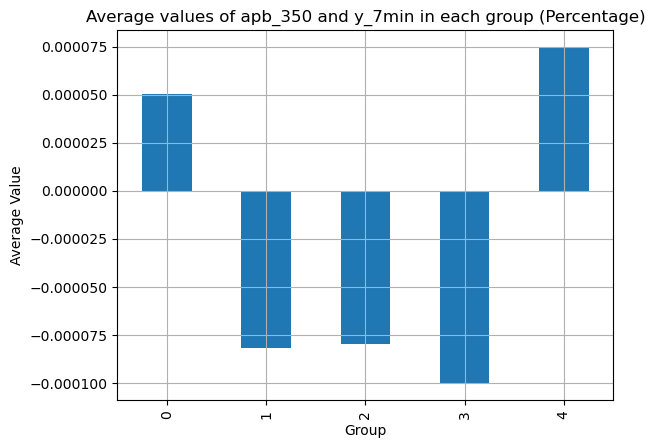

  group_percent   apb_350    y_7min
0         0-20% -0.241583  0.000051
1        20-40% -0.063702 -0.000082
2        40-60% -0.000592 -0.000080
3        60-80%  0.059777 -0.000100
4       80-100%  0.200598  0.000075


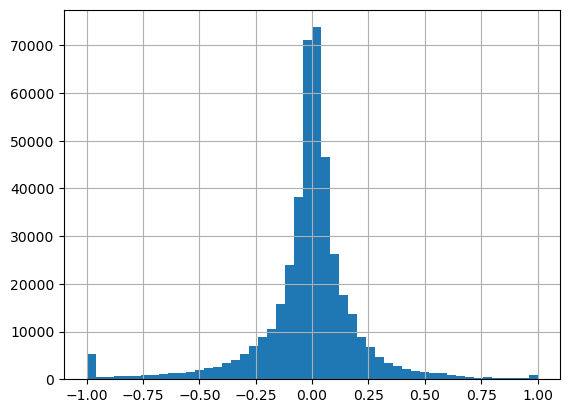

-1.0 -0.016144452036281363 1.0


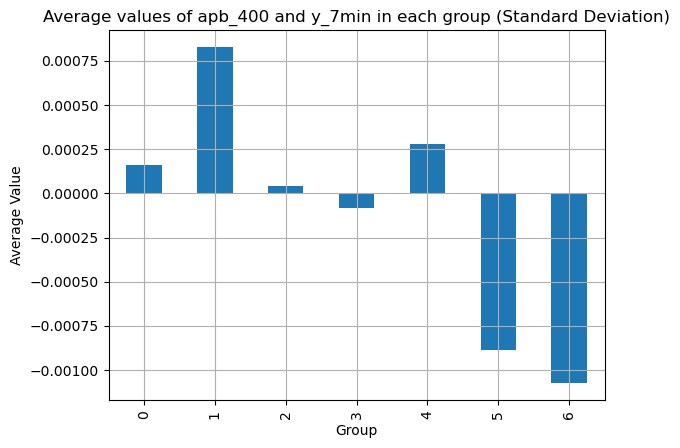

    group_std   apb_400    y_7min
0   -∞ to -3σ -0.704022  0.000162
1  -3σ to -2σ -0.546244  0.000828
2   -2σ to -σ -0.287524  0.000044
3    -σ to +σ  0.006344 -0.000082
4   +σ to +2σ  0.305765  0.000280
5  +2σ to +3σ  0.494670 -0.000888
6   +3σ to +∞  0.688628 -0.001074


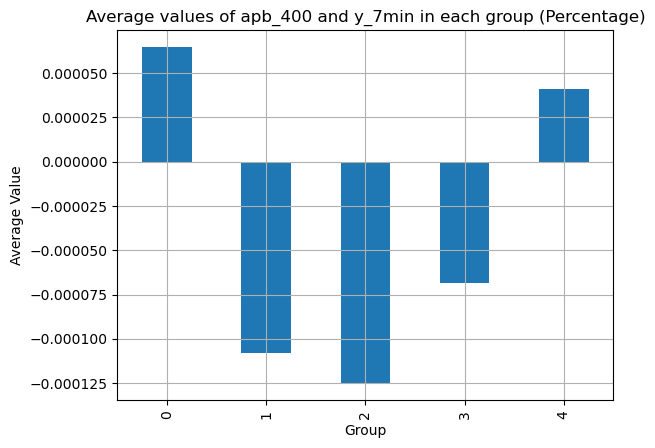

  group_percent   apb_400    y_7min
0         0-20% -0.253219  0.000065
1        20-40% -0.069154 -0.000108
2        40-60% -0.000809 -0.000125
3        60-80%  0.063945 -0.000068
4       80-100%  0.210903  0.000041


In [25]:
for back_ticks in [140, 160, 200, 250, 300, 350, 400]:
    assess_apb_wrt_return(data, back_ticks, 'y_7min')

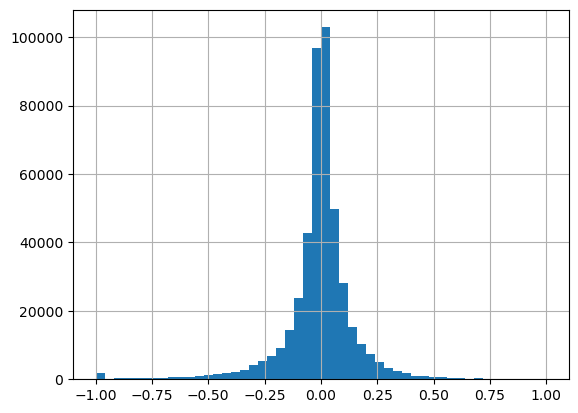

-1.0 -0.00835908816766424 1.0


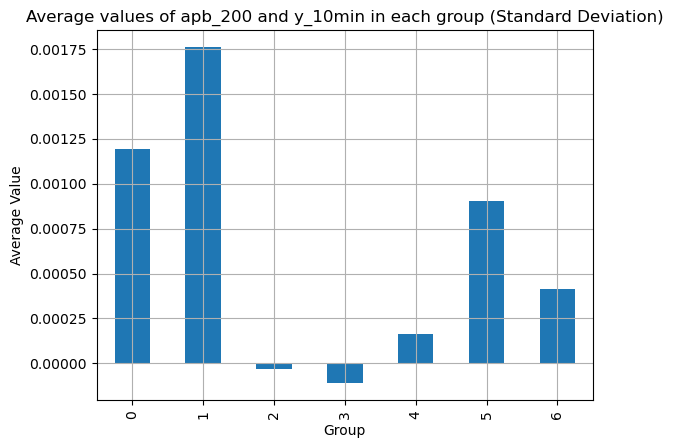

    group_std   apb_200   y_10min
0   -∞ to -3σ -0.611562  0.001194
1  -3σ to -2σ -0.359245  0.001762
2   -2σ to -σ -0.209366 -0.000034
3    -σ to +σ  0.004681 -0.000110
4   +σ to +2σ  0.204853  0.000162
5  +2σ to +3σ  0.333205  0.000905
6   +3σ to +∞  0.581511  0.000415


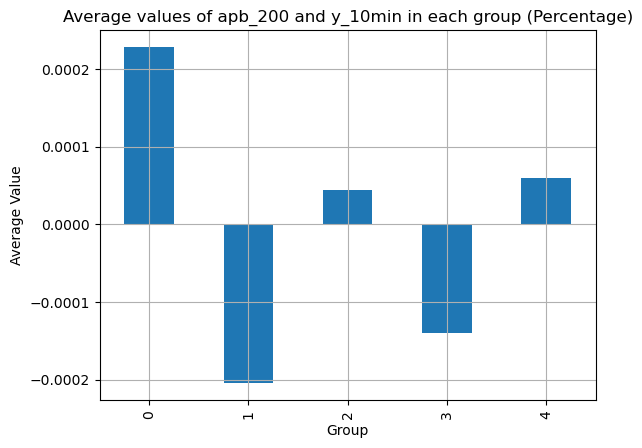

  group_percent   apb_200   y_10min
0         0-20% -0.192105  0.000228
1        20-40% -0.045068 -0.000204
2        40-60%  0.001983  0.000044
3        60-80%  0.045596 -0.000140
4       80-100%  0.155294  0.000059


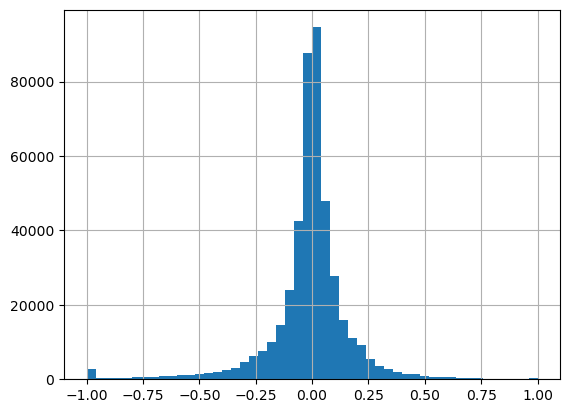

-1.0 -0.010633815327621818 1.0


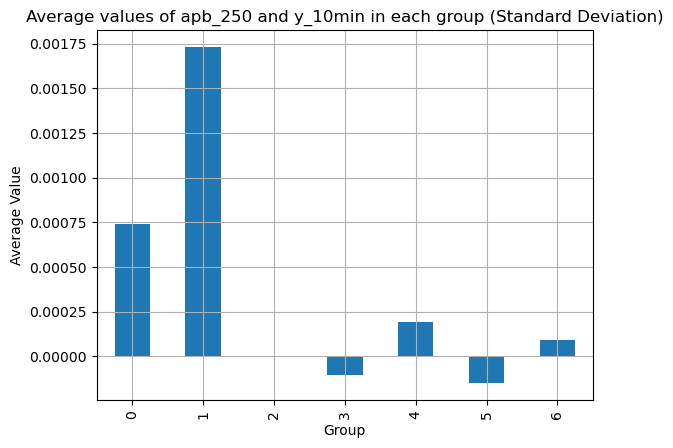

    group_std   apb_250   y_10min
0   -∞ to -3σ -0.658627  0.000738
1  -3σ to -2σ -0.405648  0.001732
2   -2σ to -σ -0.230407  0.000002
3    -σ to +σ  0.005041 -0.000104
4   +σ to +2σ  0.228717  0.000191
5  +2σ to +3σ  0.382246 -0.000150
6   +3σ to +∞  0.625479  0.000091


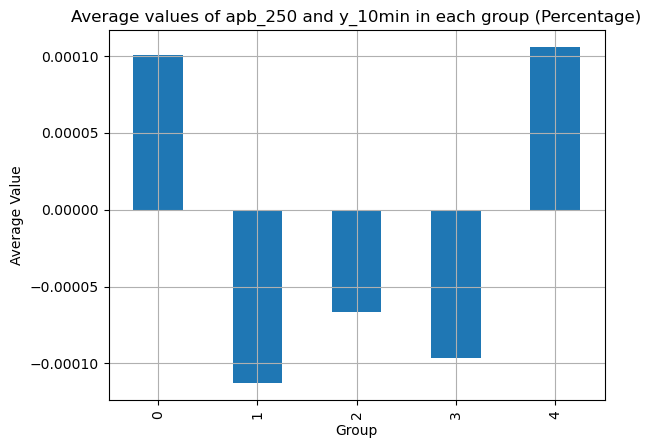

  group_percent   apb_250   y_10min
0         0-20% -0.211307  0.000101
1        20-40% -0.052303 -0.000113
2        40-60%  0.000817 -0.000066
3        60-80%  0.050955 -0.000096
4       80-100%  0.172544  0.000106


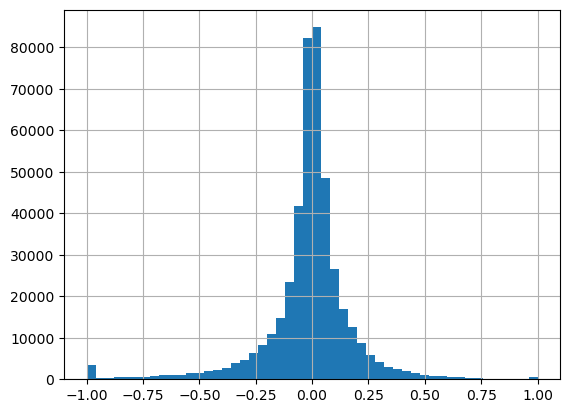

-1.0 -0.012632132679902446 1.0


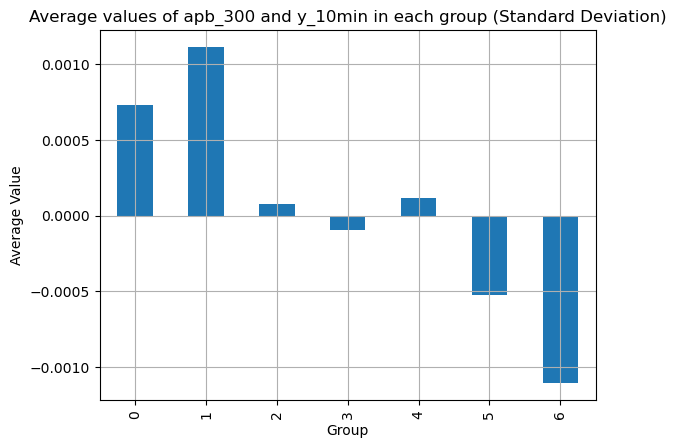

    group_std   apb_300   y_10min
0   -∞ to -3σ -0.675800  0.000734
1  -3σ to -2σ -0.443899  0.001114
2   -2σ to -σ -0.252577  0.000080
3    -σ to +σ  0.005415 -0.000097
4   +σ to +2σ  0.258028  0.000114
5  +2σ to +3σ  0.428285 -0.000524
6   +3σ to +∞  0.645125 -0.001106


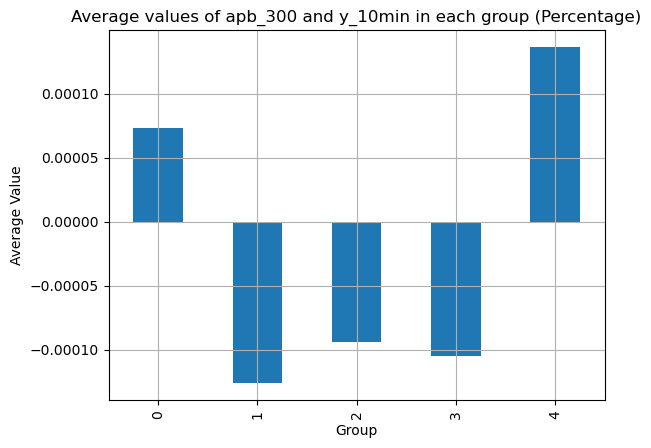

  group_percent   apb_300   y_10min
0         0-20% -0.228008  0.000074
1        20-40% -0.059922 -0.000126
2        40-60%  0.000275 -0.000094
3        60-80%  0.056083 -0.000105
4       80-100%  0.186682  0.000137


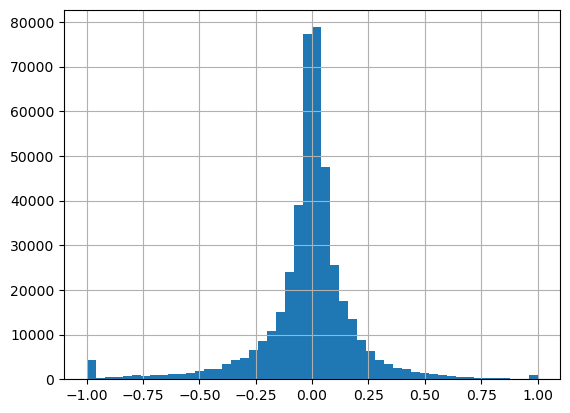

-1.0 -0.014477709131384357 1.0


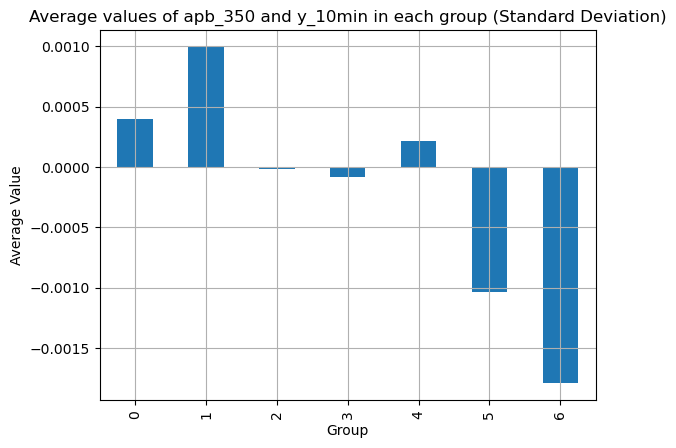

    group_std   apb_350   y_10min
0   -∞ to -3σ -0.698091  0.000401
1  -3σ to -2σ -0.488138  0.000994
2   -2σ to -σ -0.267127 -0.000019
3    -σ to +σ  0.006355 -0.000084
4   +σ to +2σ  0.283730  0.000213
5  +2σ to +3σ  0.463676 -0.001034
6   +3σ to +∞  0.656925 -0.001789


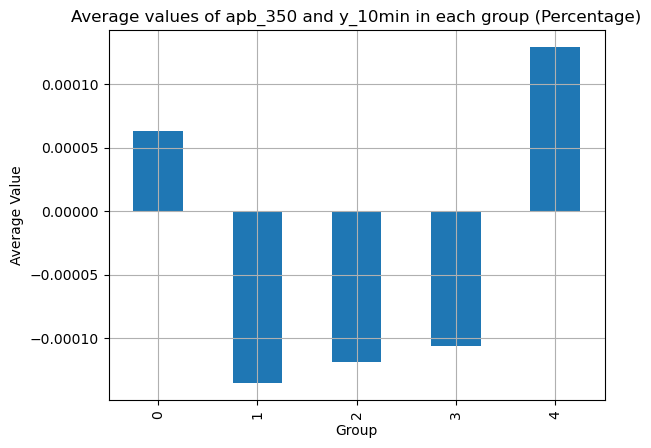

  group_percent   apb_350   y_10min
0         0-20% -0.241583  0.000063
1        20-40% -0.063702 -0.000135
2        40-60% -0.000592 -0.000119
3        60-80%  0.059777 -0.000106
4       80-100%  0.200598  0.000129


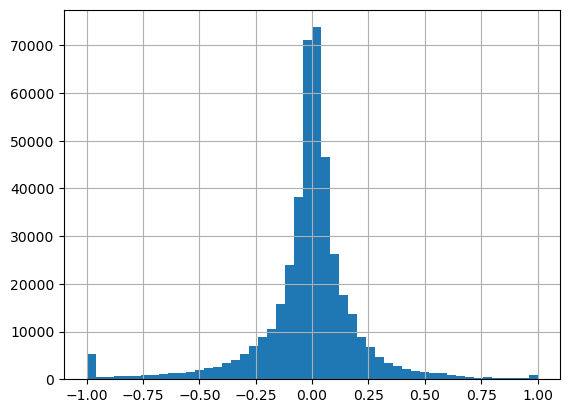

-1.0 -0.016144452036281363 1.0


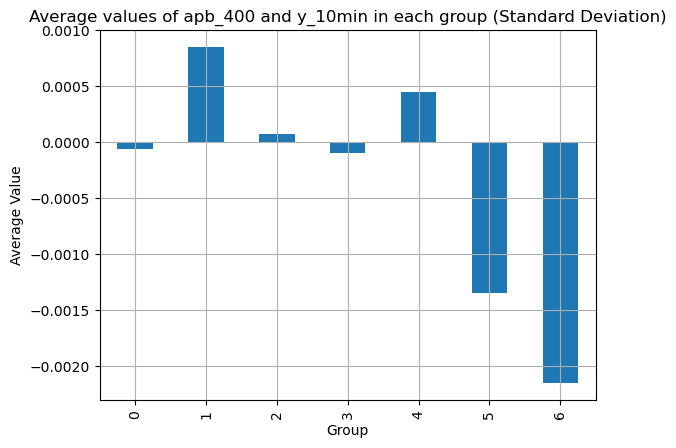

    group_std   apb_400   y_10min
0   -∞ to -3σ -0.704022 -0.000059
1  -3σ to -2σ -0.546244  0.000851
2   -2σ to -σ -0.287524  0.000077
3    -σ to +σ  0.006344 -0.000093
4   +σ to +2σ  0.305765  0.000447
5  +2σ to +3σ  0.494670 -0.001344
6   +3σ to +∞  0.688628 -0.002152


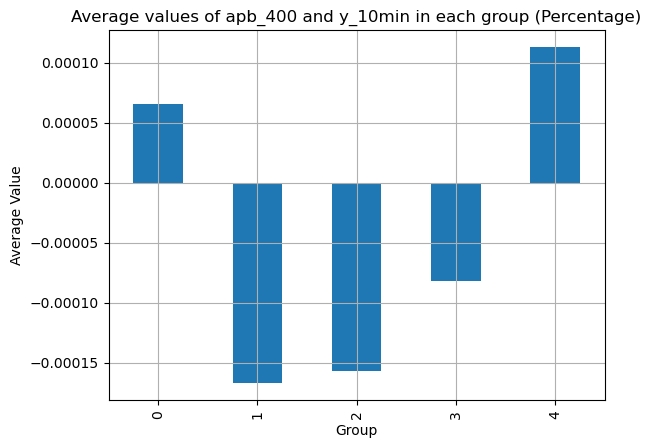

  group_percent   apb_400   y_10min
0         0-20% -0.253219  0.000066
1        20-40% -0.069154 -0.000167
2        40-60% -0.000809 -0.000157
3        60-80%  0.063945 -0.000082
4       80-100%  0.210903  0.000113


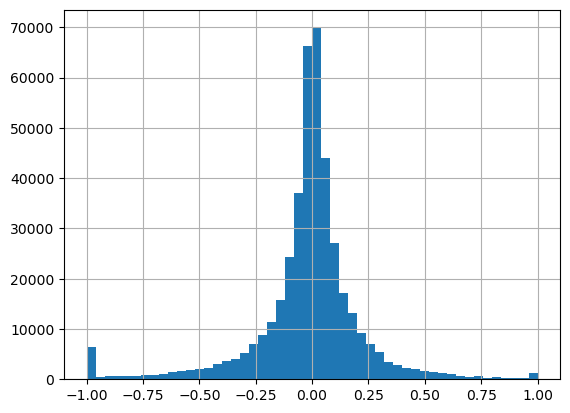

-1.0 -0.01799170158960491 1.0


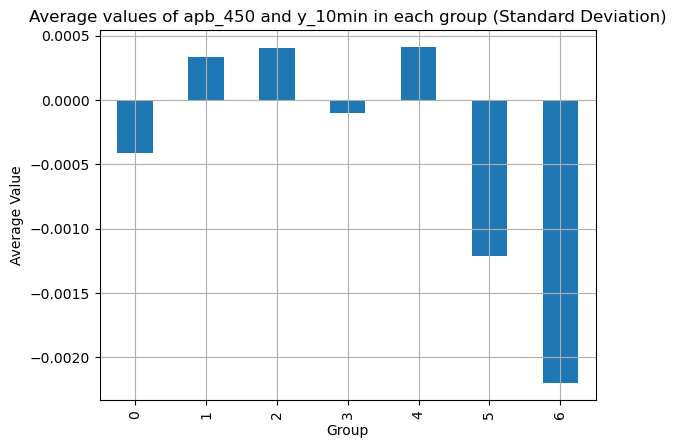

    group_std   apb_450   y_10min
0   -∞ to -3σ -0.736452 -0.000412
1  -3σ to -2σ -0.558096  0.000339
2   -2σ to -σ -0.305476  0.000407
3    -σ to +σ  0.005989 -0.000097
4   +σ to +2σ  0.323077  0.000413
5  +2σ to +3σ  0.511095 -0.001212
6   +3σ to +∞  0.728432 -0.002201


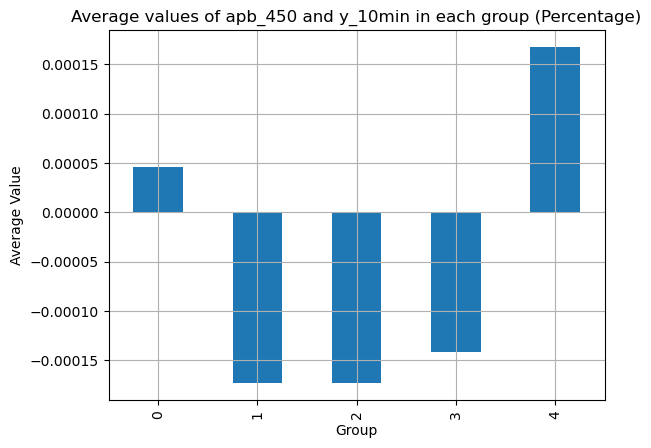

  group_percent   apb_450   y_10min
0         0-20% -0.262923  0.000046
1        20-40% -0.072790 -0.000173
2        40-60% -0.001648 -0.000173
3        60-80%  0.066520 -0.000142
4       80-100%  0.219464  0.000167


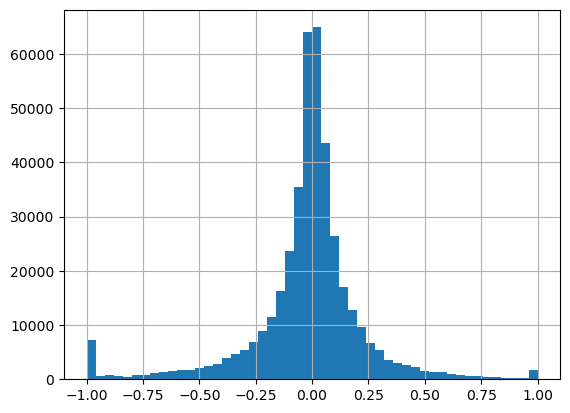

-1.0 -0.019912945795696923 1.0


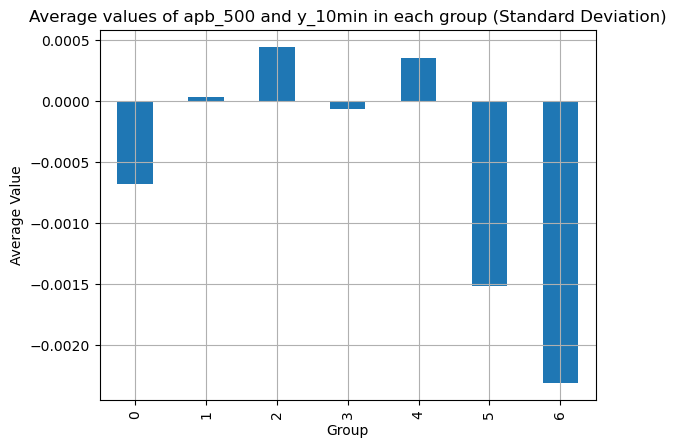

    group_std   apb_500   y_10min
0   -∞ to -3σ -0.755878 -0.000679
1  -3σ to -2σ -0.573775  0.000036
2   -2σ to -σ -0.318455  0.000446
3    -σ to +σ  0.005695 -0.000064
4   +σ to +2σ  0.337747  0.000355
5  +2σ to +3σ  0.546349 -0.001515
6   +3σ to +∞  0.751087 -0.002309


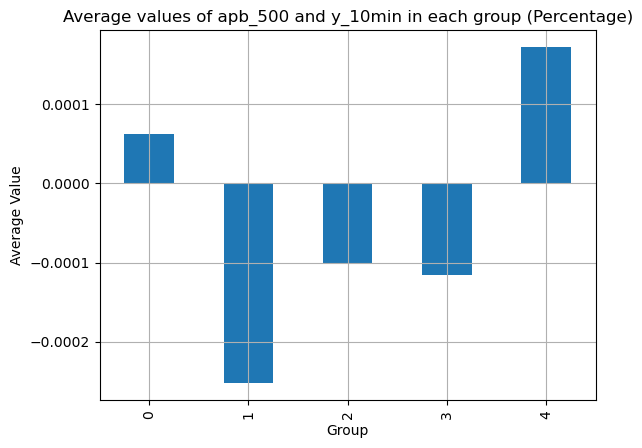

  group_percent   apb_500   y_10min
0         0-20% -0.273233  0.000062
1        20-40% -0.078189 -0.000252
2        40-60% -0.002459 -0.000101
3        60-80%  0.068950 -0.000116
4       80-100%  0.230780  0.000172


In [26]:
for back_ticks in [200, 250, 300, 350, 400, 450, 500]:
    assess_apb_wrt_return(data, back_ticks, 'y_10min')